In [ ]:
#Necessary packages
!pip install pandas numpy scikit-learn matplotlib seaborn geemap -q

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_validate
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 16.4 MB/s eta 0:00:00


In [ ]:
import ee

# Trigger the authentication flow.
ee.Authenticate()
print("Work 1!!")

# Initialize the library.
ee.Initialize(project='usask-468318')
print("Work 2!!")

Work 1!!
Work 2!!


In [ ]:
# Your study area boundary
SLPP = ee.FeatureCollection("projects/usask-468318/assets/SLPP")
# Plots
plots = ee.FeatureCollection("projects/usask-468318/assets/Presence_Absence_Sites")
# Load smoothed NDVI time series (already created in GEE)
ndviTimeSeries = ee.Image('users/Usask_Thesis/Smoothed_Sentinel_RGR_10_Day_24_19_iNaturalists').clip(SLPP)

# Method 2: Get all band names and remove specific ones
all_bands = ndviTimeSeries.bandNames()
# Bands to remove (non-growing season)
bands_to_remove = ee.List([
    't00', 't01', 't02', 't03', 't04', 't05', 't06','t07','t08', 't31', 't32', 't33', 't34', 't35'])
# Remove unwanted bands
filtered_bands = all_bands.removeAll(bands_to_remove)

# Select only filtered bands
filtered_image = ndviTimeSeries.select(filtered_bands)
# Print size
print(f"Plot data size: {plots.size().getInfo()}")
# Check NDVI bands
band_names = ndviTimeSeries.bandNames().getInfo()
print(f"\nNDVI bands: {len(band_names)} total")
print(f"First 10 bands: {band_names[:10]}")
print(f"Last 10 bands: {band_names[-10:]}")


Plot data size: 127

NDVI bands: 36 total
First 10 bands: ['t00', 't01', 't02', 't03', 't04', 't05', 't06', 't07', 't08', 't09']
Last 10 bands: ['t26', 't27', 't28', 't29', 't30', 't31', 't32', 't33', 't34', 't35']


In [ ]:
import geemap

# Create interactive map
Map = geemap.Map()

# Center on your study area
Map.centerObject(SLPP, 12)

# Add boundary and plots
Map.addLayer(SLPP, {'color': 'yellow'}, 'SLPP Boundary')
Map.addLayer(plots, {'color': 'red'}, 'Plot Data')

# Get all band names from FILTERED image
band_list = filtered_bands.getInfo()

print(f"Adding {len(band_list)} NDVI bands to map...")

# Add each NDVI band (all unchecked initially)
for i, band_name in enumerate(band_list):
    Map.addLayer(
        filtered_image.select(band_name),
        {
            'min': 0,
            'max': 1,
            'palette': ['red', 'yellow', 'green']
        },
        f'NDVI {band_name}',
        False  # False = unchecked initially
    )

    # Print progress every 10 bands
    if (i + 1) % 10 == 0:
        print(f"  Added {i + 1}/{len(band_list)} bands...")

print(f"✅ All {len(band_list)} NDVI bands added to map!")
print("Toggle layers on/off in the Layers panel →")

# Display the map
Map


Adding 22 NDVI bands to map...
  Added 10/22 bands...
  Added 20/22 bands...
✅ All 22 NDVI bands added to map!
Toggle layers on/off in the Layers panel →


Map(center=[50.664448949104, -107.99542180658446], controls=(WidgetControl(options=['position', 'transparent_b…

In [ ]:
# Add class labels (0 = Presence, 1 = Absence)
def add_class_label(feature):
    Type = feature.get('Type')
    class_label = ee.Algorithms.If(ee.String(Type).equals('Presence'), 0, 1)
    return feature.set('class', class_label)

trainingData = plots.map(add_class_label)

# Or display by species with different colors
PPoints = trainingData.filter(ee.Filter.eq('Type', 'Presence'))
APoints = trainingData.filter(ee.Filter.eq('Type', 'Absence'))

# Print sizes
print(PPoints.size().getInfo(), "Presence POINT")
print(APoints.size().getInfo(), "Absence POINT")

38 Presence POINT
89 Absence POINT


In [ ]:
# ========================================
# CREATE 20m × 20m SQUARE BUFFERS AND SAMPLE NDVI
# ========================================

# Step 1: Create function to convert points to 20m × 20m squares
def create_square_buffer(feature):
    """
    Creates a 20m × 20m square buffer around a point
    (10m in each direction from center)
    """
    # Get the point geometry
    point = feature.geometry()

    # Create a 20m × 20m square (10m radius)
    # Using buffer creates a circle, then we'll use bounds() to make it square
    square = point.buffer(10).bounds()

    # Alternative: More precise square using coordinates
    # Get point coordinates
    coords = point.coordinates()
    lon = ee.Number(coords.get(0))
    lat = ee.Number(coords.get(1))

    # Calculate corners (approximately 10m in degrees)
    # 10m ≈ 0.00009 degrees latitude
    # 10m longitude varies by latitude, but ~0.00012 at 52°N
    offset_lat = 0.00009  # 10m in latitude
    offset_lon = 0.00012  # 10m in longitude (approximate for Saskatchewan)

    # Create square polygon
    square = ee.Geometry.Rectangle([
        lon.subtract(offset_lon), lat.subtract(offset_lat),  # SW corner
        lon.add(offset_lon), lat.add(offset_lat)             # NE corner
    ])

    # Return feature with square geometry
    return feature.setGeometry(square)

# Step 2: Apply buffer to all training points
print("Creating 20m × 20m square buffers around each point...")
square_plots = trainingData.map(create_square_buffer)

# Check how many square plots you have
total_squares = square_plots.size().getInfo()
print(f"✅ Total square plots created: {total_squares}")

# Verify the buffer size
first_square = square_plots.first()
area = first_square.geometry().area()
print(f"Buffer area: {area.getInfo():.0f} m² (should be ~400 m² for 20×20m)")


trainingDataWithNDVI = filtered_image.reduceRegions(
    collection=square_plots,
    reducer=ee.Reducer.mean(),  # Average all pixels in each square
    scale=10                     # Use 10m pixels (Sentinel-2 native resolution)
)

# Step 4: Verify results
print(f"\n✅ Sampled {trainingDataWithNDVI.size().getInfo()} plots")

# Check total samples
total_samples = trainingDataWithNDVI.size().getInfo()
print(f"✅ Total samples with NDVI: {total_samples}")

# Check by class/species
P_samples = trainingDataWithNDVI.filter(ee.Filter.eq('Type', 'Presence')).size().getInfo()
A_samples = trainingDataWithNDVI.filter(ee.Filter.eq('Type', 'Absence')).size().getInfo()

print(f"  Presence samples: {P_samples}")
print(f"  Absence samples: {A_samples}")


# Check one sample
sample = trainingDataWithNDVI.first().getInfo()['properties']

ndvi_keys = [k for k in sample.keys() if k.startswith('t')]
print(f"  NDVI bands: {len(ndvi_keys)} total")
print(f"  First 5 NDVI values: {[sample[k] for k in sorted(ndvi_keys)[:5]]}")


Creating 20m × 20m square buffers around each point...
✅ Total square plots created: 127
Buffer area: 339 m² (should be ~400 m² for 20×20m)

✅ Sampled 127 plots
✅ Total samples with NDVI: 127
  Presence samples: 38
  Absence samples: 89
  NDVI bands: 22 total
  First 5 NDVI values: [1.1367145470305458, 1.1416630488178616, 1.110495047030606, 1.0547561214649672, 0.9963702189824912]


In [ ]:
import pandas as pd
from IPython.display import display

# Convert to pandas DataFrame
def ee_to_pandas(fc, limit=None):
    """Convert Earth Engine FeatureCollection to pandas DataFrame"""
    if limit:
        fc = fc.limit(limit)

    features = fc.getInfo()['features']
    data = [f['properties'] for f in features]
    return pd.DataFrame(data)

# **DEFINE YOUR DOY MAPPING HERE**
START_DAY = 2        # First band represents day 2
DAY_INTERVAL = 10     # Each subsequent band is 5 days later

# Remove site "N29" from the dataset
trainingDataWithNDVI = trainingDataWithNDVI.filter(
    ee.Filter.neq('Site', 'N29')
)

# Check total samples
total_samples = trainingDataWithNDVI.size().getInfo()
print(f"✅ Total samples available: {total_samples}")

P_samples = trainingDataWithNDVI.filter(ee.Filter.eq('Type', 'Presence')).size().getInfo()
A_samples = trainingDataWithNDVI.filter(ee.Filter.eq('Type', 'Absence')).size().getInfo()

print(f"  Presence samples: {P_samples}")
print(f"  Absence samples: {A_samples}\n")

# Download ALL data
df = ee_to_pandas(trainingDataWithNDVI)

print(f"✅ Downloaded {len(df)} samples with {len(df.columns)} columns\n")

# **Identify ALL NDVI band columns**
ndvi_cols = [col for col in df.columns if col.startswith('t') and len(col) == 3 and col[1:].isdigit()]
ndvi_cols_sorted = sorted(ndvi_cols)  # Sort to keep bands in order

print(f"📊 Found {len(ndvi_cols_sorted)} NDVI band columns")
print(f"   First 5 bands: {ndvi_cols_sorted[:5]}")
print(f"   Last 5 bands: {ndvi_cols_sorted[-5:]}\n")

# **RESHAPE DATA FROM WIDE TO LONG FORMAT**

# Create a list to store reshaped rows
long_format_data = []

for idx, row in df.iterrows():
    site = row['Site']
    type_val = row['Type']

    # For each band, create a new row
    for band_name in ndvi_cols_sorted:
        # Extract band number and calculate DOY
        band_num = int(band_name[1:])  # Remove 't' and convert to int
        doy = (band_num * DAY_INTERVAL) + START_DAY
        ndvi_value = row[band_name]

        long_format_data.append({
            'Site': site,
            'Type': type_val,
            'Band': band_name,
            'DOY': doy,
            'NDVI': ndvi_value
        })

# Create new DataFrame in long format
df_long = pd.DataFrame(long_format_data)

print(f"✅ Reshaped data: {len(df_long)} rows (from {len(df)} samples × {len(ndvi_cols_sorted)} bands)\n")

# Set pandas display options
pd.set_option('display.max_rows', 20)  # Show first/last 10 rows
pd.set_option('display.max_columns', None)

print("\nLast 15 rows:")
display(df_long)

# Save and download
df_long.to_csv('Sentinel-All-Bands-Long-Format.csv', index=False)
from google.colab import files
files.download('Sentinel-All-Bands-Long-Format.csv')


✅ Total samples available: 126
  Presence samples: 38
  Absence samples: 88

✅ Downloaded 126 samples with 28 columns

📊 Found 22 NDVI band columns
   First 5 bands: ['t09', 't10', 't11', 't12', 't13']
   Last 5 bands: ['t26', 't27', 't28', 't29', 't30']

✅ Reshaped data: 2772 rows (from 126 samples × 22 bands)


Last 15 rows:


,Site,Type,Band,DOY,NDVI
0,C30,Presence,t09,92,1.136715
1,C30,Presence,t10,102,1.141663
2,C30,Presence,t11,112,1.110495
3,C30,Presence,t12,122,1.054756
4,C30,Presence,t13,132,0.996370
...,...,...,...,...,...
2767,N16,Absence,t26,262,1.075982
2768,N16,Absence,t27,272,1.043868
2769,N16,Absence,t28,282,1.055089
2770,N16,Absence,t29,292,1.077208


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# ========================================
# GUARANTEED 80/20 STRATIFIED SPLIT
# ========================================

def stratified_split_exact(data):
    """
    Ensures EXACT 80/20 split while maintaining class proportions
    """
    # Separate classes
    cw_data = data.filter(ee.Filter.eq('class', 0))
    ng_data = data.filter(ee.Filter.eq('class', 1))

    # Get counts
    cw_total = cw_data.size().getInfo()
    ng_total = ng_data.size().getInfo()
    total = cw_total + ng_total

    # Calculate exact split for each class
    cw_train_n = int(cw_total * 0.8)
    cw_test_n = cw_total - cw_train_n

    ng_train_n = int(ng_total * 0.8)
    ng_test_n = ng_total - ng_train_n

    print(f"Target split:")
    print(f"  Presence: {cw_train_n} train, {cw_test_n} test (from {cw_total} total)")
    print(f"  Absence: {ng_train_n} train, {ng_test_n} test (from {ng_total} total)")
    print(f"  Total: {cw_train_n + ng_train_n} train ({(cw_train_n + ng_train_n)/total*100:.1f}%), "
          f"{cw_test_n + ng_test_n} test ({(cw_test_n + ng_test_n)/total*100:.1f}%)")

    # Add random column for shuffling
    cw_random = cw_data.randomColumn('random', 42)
    ng_random = ng_data.randomColumn('random', 42)

    # Sort by random column to shuffle
    cw_sorted = cw_random.sort('random')
    ng_sorted = ng_random.sort('random')

    # Take exact number for training (first 80% after shuffle)
    cw_train = cw_sorted.limit(cw_train_n)
    ng_train = ng_sorted.limit(ng_train_n)

    # Take remaining for testing (skip first 80%, take rest)
    cw_test = cw_sorted.toList(cw_total).slice(cw_train_n)
    ng_test = ng_sorted.toList(ng_total).slice(ng_train_n)

    # Convert lists back to FeatureCollections
    cw_test_fc = ee.FeatureCollection(cw_test)
    ng_test_fc = ee.FeatureCollection(ng_test)

    # Merge
    train = cw_train.merge(ng_train)
    test = cw_test_fc.merge(ng_test_fc)

    return {'train': train, 'test': test}


split_data = stratified_split_exact(trainingDataWithNDVI)

# Verify
train_total = split_data['train'].size().getInfo()
test_total = split_data['test'].size().getInfo()
total = train_total + test_total

train_cw = split_data['train'].filter(ee.Filter.eq('class', 0)).size().getInfo()
train_ng = split_data['train'].filter(ee.Filter.eq('class', 1)).size().getInfo()
test_cw = split_data['test'].filter(ee.Filter.eq('class', 0)).size().getInfo()
test_ng = split_data['test'].filter(ee.Filter.eq('class', 1)).size().getInfo()

print(f"\nActual split:")
print(f"  Training: {train_total} samples ({train_total/total*100:.1f}%)")
print(f"    - Presence: {train_cw}")
print(f"    - Absence: {train_ng}")
print(f"  Testing: {test_total} samples ({test_total/total*100:.1f}%)")
print(f"    - Presence: {test_cw}")
print(f"    - Absence: {test_ng}")

# Check if it's 80/20
train_pct = train_total / total * 100
if abs(train_pct - 80) < 1:
    print(f"\n✅ Split is exactly 80/20!")
else:
    print(f"\n⚠️  Split is {train_pct:.1f}% / {100-train_pct:.1f}%")

print("="*60)

Target split:
  Presence: 30 train, 8 test (from 38 total)
  Absence: 70 train, 18 test (from 88 total)
  Total: 100 train (79.4%), 26 test (20.6%)

Actual split:
  Training: 100 samples (79.4%)
    - Presence: 30
    - Absence: 70
  Testing: 26 samples (20.6%)
    - Presence: 8
    - Absence: 18

✅ Split is exactly 80/20!


In [ ]:
# ========================================
# HYPERPARAMETER TUNING - LOOCV WITH REDUCED RANGES
# ========================================

training_set = split_data['train']
temporal_bands = filtered_image.bandNames()
n_samples = training_set.size().getInfo()

print(f"\nTraining samples: {n_samples}")

# Step 1: Prepare data with IDs
print("\nPreparing data for LOOCV...")
training_list = training_set.toList(n_samples)

def add_id(i):
    feature = ee.Feature(training_list.get(i))
    return feature.set('loocv_id', i)

features_with_id = ee.List.sequence(0, n_samples - 1).map(add_id)
training_with_id = ee.FeatureCollection(features_with_id)
print(f"✅ Added sequential IDs (0 to {n_samples - 1})")

# ========================================
# DEFINE HYPERPARAMETER RANGES (WITH SQRT AND LOG2)
# ========================================

import itertools
import math

# Calculate number of features
n_features = temporal_bands.size().getInfo()
print(f"\nTotal NDVI features: {n_features}")

# Calculate sqrt and log2 values
vars_sqrt = int(math.sqrt(n_features))
vars_log2 = int(math.log2(n_features))

print(f"  sqrt({n_features}) = {vars_sqrt}")
print(f"  log2({n_features}) = {vars_log2}")

# FAST VERSION with automatic feature selection
trees_range = [100, 200, 400]                    # 3 values
vars_range = ['sqrt', 'log2']                # sqrt, log2, or fixed value
minLeaf_range = [1, 5, 10]                       # 3 values
bag_fraction_list = [0.7, 0.9]                   # 2 values

print("\n" + "="*60)
print("HYPERPARAMETER RANGES (OPTIMIZED FOR SPEED)")
print("="*60)
print(f"numberOfTrees: {trees_range}")
print(f"variablesPerSplit: {vars_range}")
print(f"  - 'sqrt' will use {vars_sqrt} features")
print(f"  - 'log2' will use {vars_log2} features")
print(f"  - 10 will use 10 features")
print(f"minLeafPopulation: {minLeaf_range}")
print(f"bagFraction: {bag_fraction_list}")

# Generate all combinations
param_combinations = list(itertools.product(trees_range, vars_range, minLeaf_range, bag_fraction_list))

print(f"\n📊 Total combinations to test: {len(param_combinations)}")
print(f"   3 × 3 × 3 × 2 = {3*3*3*2} configurations")
print(f"   Each config trains {n_samples} models")
print(f"   Total model trainings: {len(param_combinations) * n_samples}")
print(f"⏱️  Estimated time: ~{len(param_combinations) * n_samples * 3 / 60:.0f} minutes ({len(param_combinations) * n_samples * 3 / 3600:.1f} hours)")
print("="*60)

# Convert to list of dictionaries
param_grid = []
for idx, (trees, vars_val, minLeaf, bag_frac) in enumerate(param_combinations, 1):
    # Convert sqrt/log2 to actual numbers
    if vars_val == 'sqrt':
        actual_vars = vars_sqrt
        vars_display = f"sqrt({vars_sqrt})"
    elif vars_val == 'log2':
        actual_vars = vars_log2
        vars_display = f"log2({vars_log2})"
    else:
        actual_vars = vars_val
        vars_display = str(vars_val)

    param_grid.append({
        'name': f'Config_{idx}',
        'trees': trees,
        'vars': actual_vars,           # Actual numeric value for GEE
        'vars_type': vars_val,          # Original type (sqrt/log2/number)
        'vars_display': vars_display,   # For display
        'minLeaf': minLeaf,
        'bagFraction': bag_frac
    })

print(f"\n✅ Generated {len(param_grid)} configurations")

# Show all configurations
print("\nAll configurations to test:")
for i in range(len(param_grid)):
    p = param_grid[i]
    print(f"  {p['name']}: trees={p['trees']}, vars={p['vars_display']}, minLeaf={p['minLeaf']}, bagFrac={p['bagFraction']}")

print("\n" + "="*60)

# ========================================
# LOOCV FUNCTION (DEFINED BEFORE THE LOOP)
# ========================================

def leave_one_out_cv(params, data_with_id, bands, n):
    """Perform leave-one-out cross-validation"""
    correct = 0
    predictions_list = []

    print(f"  Running LOOCV ({n} iterations)...")

    for i in range(n):
        # Leave one out
        test_sample = data_with_id.filter(ee.Filter.eq('loocv_id', i))
        train_samples = data_with_id.filter(ee.Filter.neq('loocv_id', i))

        # Verify we have data
        test_size = test_sample.size().getInfo()
        train_size = train_samples.size().getInfo()

        if test_size == 0:
            continue
        if train_size == 0:
            continue

        # Train with bag fraction parameter
        classifier = ee.Classifier.smileRandomForest(
            numberOfTrees=params['trees'],
            variablesPerSplit=params['vars'],  # This is now the actual numeric value
            minLeafPopulation=params['minLeaf'],
            bagFraction=params['bagFraction'],
            seed=42
        )

        trained = classifier.train(
            features=train_samples,
            classProperty='class',
            inputProperties=bands
        )

        # Test on single sample
        prediction = test_sample.classify(trained)

        # Get actual and predicted classes
        test_feature = test_sample.first().getInfo()
        if test_feature is None:
            continue

        pred_feature = prediction.first().getInfo()
        if pred_feature is None:
            continue

        actual = test_feature['properties'].get('class')
        predicted = pred_feature['properties'].get('classification')

        if actual == predicted:
            correct += 1

        predictions_list.append({
            'id': i,
            'actual': actual,
            'predicted': predicted,
            'correct': actual == predicted
        })

        # Progress updates every 20 iterations
        if (i + 1) % 20 == 0:
            accuracy_so_far = correct / (i + 1) * 100
            print(f"    Progress: {i+1}/{n} ({correct}/{i+1} correct, {accuracy_so_far:.1f}%)")

    total = len(predictions_list)
    accuracy = correct / total if total > 0 else 0

    return {
        'accuracy': accuracy,
        'correct': correct,
        'total': total,
        'predictions': predictions_list
    }

# ========================================
# RUN LOOCV FOR EACH CONFIG
# ========================================

print("\n" + "="*60)
print("STARTING HYPERPARAMETER TUNING")
print("="*60)

results = []
import time
start_time = time.time()

for idx, params in enumerate(param_grid, 1):
    config_start = time.time()

    print(f"\n[{idx}/{len(param_grid)}] {params['name']}: trees={params['trees']}, vars={params['vars_display']}, minLeaf={params['minLeaf']}, bagFrac={params['bagFraction']}")

    loocv_result = leave_one_out_cv(params, training_with_id, temporal_bands, n_samples)

    result = {
        'config': params['name'],
        'trees': params['trees'],
        'vars': params['vars'],            # Numeric value
        'vars_type': params['vars_type'],  # sqrt/log2/number
        'vars_display': params['vars_display'],  # For readability
        'minLeaf': params['minLeaf'],
        'bagFraction': params['bagFraction'],
        'accuracy': loocv_result['accuracy'],
        'correct': loocv_result['correct'],
        'total': loocv_result['total']
    }
    results.append(result)

    config_time = time.time() - config_start
    elapsed_total = time.time() - start_time
    remaining_configs = len(param_grid) - idx
    estimated_remaining = (elapsed_total / idx) * remaining_configs

    print(f"  ✅ LOOCV Accuracy: {loocv_result['accuracy']*100:.2f}% ({loocv_result['correct']}/{loocv_result['total']})")
    print(f"  ⏱️  Config time: {config_time/60:.1f} min | Elapsed: {elapsed_total/60:.1f} min | ETA: {estimated_remaining/60:.1f} min")

    # Show current best so far
    current_best = max(results, key=lambda x: x['accuracy'])
    print(f"  🏆 Best so far: {current_best['accuracy']*100:.2f}% (trees={current_best['trees']}, vars={current_best['vars_display']}, minLeaf={current_best['minLeaf']}, bagFrac={current_best['bagFraction']})")

# ========================================
# FINAL RESULTS
# ========================================

total_time = time.time() - start_time

print("\n" + "="*60)
print("HYPERPARAMETER TUNING COMPLETE!")
print("="*60)
print(f"Total time: {total_time/3600:.2f} hours ({total_time/60:.1f} minutes)")
print(f"Tested {len(param_grid)} configurations")
print(f"Speed improvement: Tested 54 configs instead of 375 (7x faster!)")
print("="*60)

# Sort results
results_sorted = sorted(results, key=lambda x: x['accuracy'], reverse=True)

print("\n" + "="*60)
print("ALL CONFIGURATIONS (RANKED BY ACCURACY)")
print("="*60)
for i, r in enumerate(results_sorted, 1):
    print(f"{i}. {r['config']}: {r['accuracy']*100:.2f}% ({r['correct']}/{r['total']})")
    print(f"   trees={r['trees']}, vars={r['vars_display']}, minLeaf={r['minLeaf']}, bagFrac={r['bagFraction']}")

# Best configuration
best = results_sorted[0]

print("\n" + "="*60)
print("🏆 BEST HYPERPARAMETERS (LOOCV)")
print("="*60)
print(f"Configuration: {best['config']}")
print(f"  numberOfTrees: {best['trees']}")
print(f"  variablesPerSplit: {best['vars']} ({best['vars_type']})")
print(f"  minLeafPopulation: {best['minLeaf']}")
print(f"  bagFraction: {best['bagFraction']}")
print(f"  LOOCV Accuracy: {best['accuracy']*100:.2f}%")
print(f"  Correct predictions: {best['correct']}/{best['total']}")
print("="*60)

best_params = {
    'numberOfTrees': best['trees'],
    'variablesPerSplit': best['vars'],
    'minLeafPopulation': best['minLeaf'],
    'bagFraction': best['bagFraction']
}

print("\n✅ Best parameters saved in 'best_params'")

# ========================================
# SAVE RESULTS TO CSV
# ========================================

print("\n📊 Saving all results to CSV...")

import pandas as pd

results_df = pd.DataFrame(results)
results_df = results_df.sort_values('accuracy', ascending=False)
results_df.to_csv('loocv_hyperparameter_results_fast.csv', index=False)

print("✅ Results saved to 'loocv_hyperparameter_results_fast.csv'")
print("\nYou can download this file to analyze results")

# ========================================
# SUMMARY STATISTICS
# ========================================

print("\n" + "="*60)
print("SUMMARY STATISTICS")
print("="*60)

accuracies = [r['accuracy'] for r in results]
print(f"Average accuracy across all configs: {sum(accuracies)/len(accuracies)*100:.2f}%")
print(f"Best accuracy: {max(accuracies)*100:.2f}%")
print(f"Worst accuracy: {min(accuracies)*100:.2f}%")
print(f"Range: {(max(accuracies)-min(accuracies))*100:.2f}%")

# Analysis by vars_type
print("\n" + "="*60)
print("PERFORMANCE BY VARIABLE SELECTION METHOD")
print("="*60)

for vars_type in ['sqrt', 'log2', 10]:
    type_results = [r for r in results if r['vars_type'] == vars_type]
    if type_results:
        type_accuracies = [r['accuracy'] for r in type_results]
        avg_acc = sum(type_accuracies) / len(type_accuracies) * 100
        if vars_type == 'sqrt':
            print(f"sqrt ({vars_sqrt} features): Average accuracy = {avg_acc:.2f}%")
        elif vars_type == 'log2':
            print(f"log2 ({vars_log2} features): Average accuracy = {avg_acc:.2f}%")
        else:
            print(f"Fixed (10 features): Average accuracy = {avg_acc:.2f}%")

print("="*60)


Training samples: 100

Preparing data for LOOCV...
✅ Added sequential IDs (0 to 99)

Total NDVI features: 22
  sqrt(22) = 4
  log2(22) = 4

HYPERPARAMETER RANGES (OPTIMIZED FOR SPEED)
numberOfTrees: [100, 200, 400]
variablesPerSplit: ['sqrt', 'log2']
  - 'sqrt' will use 4 features
  - 'log2' will use 4 features
  - 10 will use 10 features
minLeafPopulation: [1, 5, 10]
bagFraction: [0.7, 0.9]

📊 Total combinations to test: 36
   3 × 3 × 3 × 2 = 54 configurations
   Each config trains 100 models
   Total model trainings: 3600
⏱️  Estimated time: ~180 minutes (3.0 hours)

✅ Generated 36 configurations

All configurations to test:
  Config_1: trees=100, vars=sqrt(4), minLeaf=1, bagFrac=0.7
  Config_2: trees=100, vars=sqrt(4), minLeaf=1, bagFrac=0.9
  Config_3: trees=100, vars=sqrt(4), minLeaf=5, bagFrac=0.7
  Config_4: trees=100, vars=sqrt(4), minLeaf=5, bagFrac=0.9
  Config_5: trees=100, vars=sqrt(4), minLeaf=10, bagFrac=0.7
  Config_6: trees=100, vars=sqrt(4), minLeaf=10, bagFrac=0.9
  

In [ ]:
# ========================================
# STEP 1: RFE ON TRAINING SET ONLY
# (To avoid data leakage - don't use test set!)
# ========================================
import time
import numpy as np

# Get training set
training_set = split_data['train']
n_train_samples = training_set.size().getInfo()

# Get all feature names
all_features = filtered_bands.getInfo()
n_features_total = len(all_features)

# ========================================
# RFE CONFIGURATION
# ========================================

STOPPING_STRATEGY = "absolute_drop"
absolute_drop_threshold = 2.0  # Stop if accuracy drops >2%
elimination_step = 1  # Remove 1 feature per iteration
min_features = 5  # Safety limit
max_iterations = 20  # Safety limit


# ========================================
# RFE HELPER FUNCTIONS (TRAINING SET ONLY)
# ========================================
def rfe_train_test_iteration(features_list, train_data, hyperparams):
    """
    Perform internal 5-fold CV on TRAINING SET ONLY
    Returns average accuracy across folds
    """
    from sklearn.model_selection import StratifiedKFold

    # We'll do 5-fold CV within training set for speed
    n_folds = 10

    # Create stratified folds within training set
    train_cw = train_data.filter(ee.Filter.eq('class', 0))
    train_ng = train_data.filter(ee.Filter.eq('class', 1))

    cw_total = train_cw.size().getInfo()
    ng_total = train_ng.size().getInfo()

    # Add random column and sort
    cw_random = train_cw.randomColumn('rfe_fold', 42)
    ng_random = train_ng.randomColumn('rfe_fold', 42)
    cw_sorted = cw_random.sort('rfe_fold')
    ng_sorted = ng_random.sort('rfe_fold')

    # Convert to lists
    cw_list = cw_sorted.toList(cw_total)
    ng_list = ng_sorted.toList(ng_total)

    # Calculate fold sizes
    cw_fold_size = int(cw_total / n_folds)
    ng_fold_size = int(ng_total / n_folds)

    fold_accuracies = []
    bands_to_use = ee.List(features_list)

    for fold_idx in range(n_folds):
        # Create test fold
        cw_test_start = fold_idx * cw_fold_size
        cw_test_end = (fold_idx + 1) * cw_fold_size if fold_idx < n_folds - 1 else cw_total

        ng_test_start = fold_idx * ng_fold_size
        ng_test_end = (fold_idx + 1) * ng_fold_size if fold_idx < n_folds - 1 else ng_total

        cw_test_fold = ee.FeatureCollection(cw_list.slice(cw_test_start, cw_test_end))
        ng_test_fold = ee.FeatureCollection(ng_list.slice(ng_test_start, ng_test_end))

        test_fold = cw_test_fold.merge(ng_test_fold)

        # Create train fold (all except test)
        cw_train_part1 = ee.FeatureCollection(cw_list.slice(0, cw_test_start))
        cw_train_part2 = ee.FeatureCollection(cw_list.slice(cw_test_end, cw_total))

        ng_train_part1 = ee.FeatureCollection(ng_list.slice(0, ng_test_start))
        ng_train_part2 = ee.FeatureCollection(ng_list.slice(ng_test_end, ng_total))

        train_fold = cw_train_part1.merge(cw_train_part2).merge(ng_train_part1).merge(ng_train_part2)

        # Train classifier
        classifier = ee.Classifier.smileRandomForest(
            numberOfTrees=hyperparams['numberOfTrees'],
            variablesPerSplit=hyperparams['variablesPerSplit'],
            minLeafPopulation=hyperparams['minLeafPopulation'],
            bagFraction=hyperparams['bagFraction'],
            seed=42
        )

        trained = classifier.train(
            features=train_fold,
            classProperty='class',
            inputProperties=bands_to_use
        )

        # Predict
        predictions = test_fold.classify(trained)

        # Get accuracy
        error_matrix = predictions.errorMatrix('class', 'classification')
        accuracy = error_matrix.accuracy().getInfo()

        fold_accuracies.append(accuracy)

    return {
        'accuracy_mean': np.mean(fold_accuracies),
        'accuracy_std': np.std(fold_accuracies)
    }

def get_feature_importance_train(features_list, training_data, hyperparams):
    """
    Train on training set only and get feature importance
    """
    bands_to_use = ee.List(features_list)

    classifier = ee.Classifier.smileRandomForest(
        numberOfTrees=hyperparams['numberOfTrees'],
        variablesPerSplit=hyperparams['variablesPerSplit'],
        minLeafPopulation=hyperparams['minLeafPopulation'],
        bagFraction=hyperparams['bagFraction'],
        seed=42
    )

    trained = classifier.train(
        features=training_data,
        classProperty='class',
        inputProperties=bands_to_use
    )

    explanation = trained.explain().getInfo()
    importance_dict = explanation.get('importance', {})

    return importance_dict


# ========================================
# RFE MAIN LOOP (ON TRAINING SET ONLY)
# ========================================

rfe_results = []
current_features = all_features.copy()
iteration = 0

start_time = time.time()

print(f"\n{'='*60}")
print("STARTING RFE ON TRAINING SET...")
print(f"{'='*60}\n")

while True:
    iteration += 1
    iter_start = time.time()

    n_current = len(current_features)

    print(f"{'='*60}")
    print(f"RFE ITERATION {iteration}")
    print(f"{'='*60}")
    print(f"Current features: {n_current}")

    # Evaluate with 5-fold CV on training set
    print(f"\n  Running 5-fold CV on training set...")
    cv_results = rfe_train_test_iteration(current_features, training_set, best_params)

    accuracy = cv_results['accuracy_mean']

    # Calculate drops
    if len(rfe_results) > 0:
        baseline_accuracy = rfe_results[0]['accuracy_mean']
        drop_from_baseline = (baseline_accuracy - accuracy) * 100
    else:
        baseline_accuracy = accuracy
        drop_from_baseline = 0

    print(f"\n  ✅ 5-Fold CV Results:")
    print(f"     Accuracy: {accuracy*100:.2f}% (±{cv_results['accuracy_std']*100:.2f}%)")

    if len(rfe_results) > 0:
        print(f"     Drop from baseline: {drop_from_baseline:.2f} percentage points")

    # Store results
    rfe_results.append({
        'iteration': iteration,
        'n_features': n_current,
        'features': current_features.copy(),
        'accuracy_mean': accuracy,
        'accuracy_std': cv_results['accuracy_std'],
        'drop_from_baseline': drop_from_baseline / 100
    })

    # Check stopping condition
    should_stop = False

    if len(rfe_results) > 1:
        if drop_from_baseline > absolute_drop_threshold:
            should_stop = True
            print(f"\n  🛑 STOPPING: Accuracy dropped by {drop_from_baseline:.2f}% (threshold: {absolute_drop_threshold}%)")

    if n_current <= min_features:
        should_stop = True
        print(f"\n  🛑 STOPPING: Reached minimum features ({min_features})")

    if iteration >= max_iterations:
        should_stop = True
        print(f"\n  🛑 STOPPING: Reached maximum iterations ({max_iterations})")

    if should_stop:
        if len(rfe_results) > 1:
            optimal_iter = rfe_results[-2]  # Previous iteration
            print(f"\n  ✅ OPTIMAL: Iteration {optimal_iter['iteration']} with {optimal_iter['n_features']} features")
        else:
            optimal_iter = rfe_results[-1]
            print(f"\n  ✅ OPTIMAL: Keeping all {optimal_iter['n_features']} features")
        break

    # Continue: Get feature importance
    print(f"\n  ➡️  Extracting feature importance...")
    importance_dict = get_feature_importance_train(current_features, training_set, best_params)

    # Sort by importance
    sorted_features = sorted(importance_dict.items(), key=lambda x: x[1])

    # Remove least important
    n_to_remove = min(elimination_step, len(current_features) - min_features)
    features_to_remove = [feat for feat, _ in sorted_features[:n_to_remove]]

    print(f"\n  🗑️  Removing: {features_to_remove}")
    current_features = [f for f in current_features if f not in features_to_remove]

    iter_time = time.time() - iter_start
    print(f"\n  ⏱️  Iteration time: {iter_time/60:.1f} min")

total_time = time.time() - start_time

# Find best iteration
best_rfe = max(rfe_results, key=lambda x: x['accuracy_mean'])
rfe_selected_features = best_rfe['features']

print("\n" + "="*60)
print("🎉 RFE COMPLETE!")
print("="*60)
print(f"Total time: {total_time/60:.1f} minutes")
print(f"\n🏆 OPTIMAL FEATURES:")
print(f"   Number: {best_rfe['n_features']}")
print(f"   Features: {rfe_selected_features}")
print(f"   Training CV Accuracy: {best_rfe['accuracy_mean']*100:.2f}% (±{best_rfe['accuracy_std']*100:.2f}%)")





STARTING RFE ON TRAINING SET...

RFE ITERATION 1
Current features: 22

  Running 5-fold CV on training set...

  ✅ 5-Fold CV Results:
     Accuracy: 80.00% (±12.65%)

  ➡️  Extracting feature importance...

  🗑️  Removing: ['t11']

  ⏱️  Iteration time: 0.1 min
RFE ITERATION 2
Current features: 21

  Running 5-fold CV on training set...

  ✅ 5-Fold CV Results:
     Accuracy: 81.00% (±13.00%)
     Drop from baseline: -1.00 percentage points

  ➡️  Extracting feature importance...

  🗑️  Removing: ['t16']

  ⏱️  Iteration time: 0.1 min
RFE ITERATION 3
Current features: 20

  Running 5-fold CV on training set...

  ✅ 5-Fold CV Results:
     Accuracy: 81.00% (±10.44%)
     Drop from baseline: -1.00 percentage points

  ➡️  Extracting feature importance...

  🗑️  Removing: ['t15']

  ⏱️  Iteration time: 0.1 min
RFE ITERATION 4
Current features: 19

  Running 5-fold CV on training set...

  ✅ 5-Fold CV Results:
     Accuracy: 80.00% (±13.42%)
     Drop from baseline: 0.00 percentage points



STARTING RFE ON TRAINING SET...

RFE ITERATION 1
Current features: 22

  Running 5-fold CV on training set...

  ✅ 5-Fold CV Results:
     Accuracy: 80.00% (±12.65%)

  ➡️  Extracting feature importance...

  🗑️  Removing: ['t11']

  ⏱️  Iteration time: 0.1 min
RFE ITERATION 2
Current features: 21

  Running 5-fold CV on training set...

  ✅ 5-Fold CV Results:
     Accuracy: 81.00% (±13.00%)
     Drop from baseline: -1.00 percentage points

  ➡️  Extracting feature importance...

  🗑️  Removing: ['t16']

  ⏱️  Iteration time: 0.0 min
RFE ITERATION 3
Current features: 20

  Running 5-fold CV on training set...

  ✅ 5-Fold CV Results:
     Accuracy: 81.00% (±10.44%)
     Drop from baseline: -1.00 percentage points

  ➡️  Extracting feature importance...

  🗑️  Removing: ['t15']

  ⏱️  Iteration time: 0.1 min
RFE ITERATION 4
Current features: 19

  Running 5-fold CV on training set...

  ✅ 5-Fold CV Results:
     Accuracy: 80.00% (±13.42%)
     Drop from baseline: 0.00 percentage points


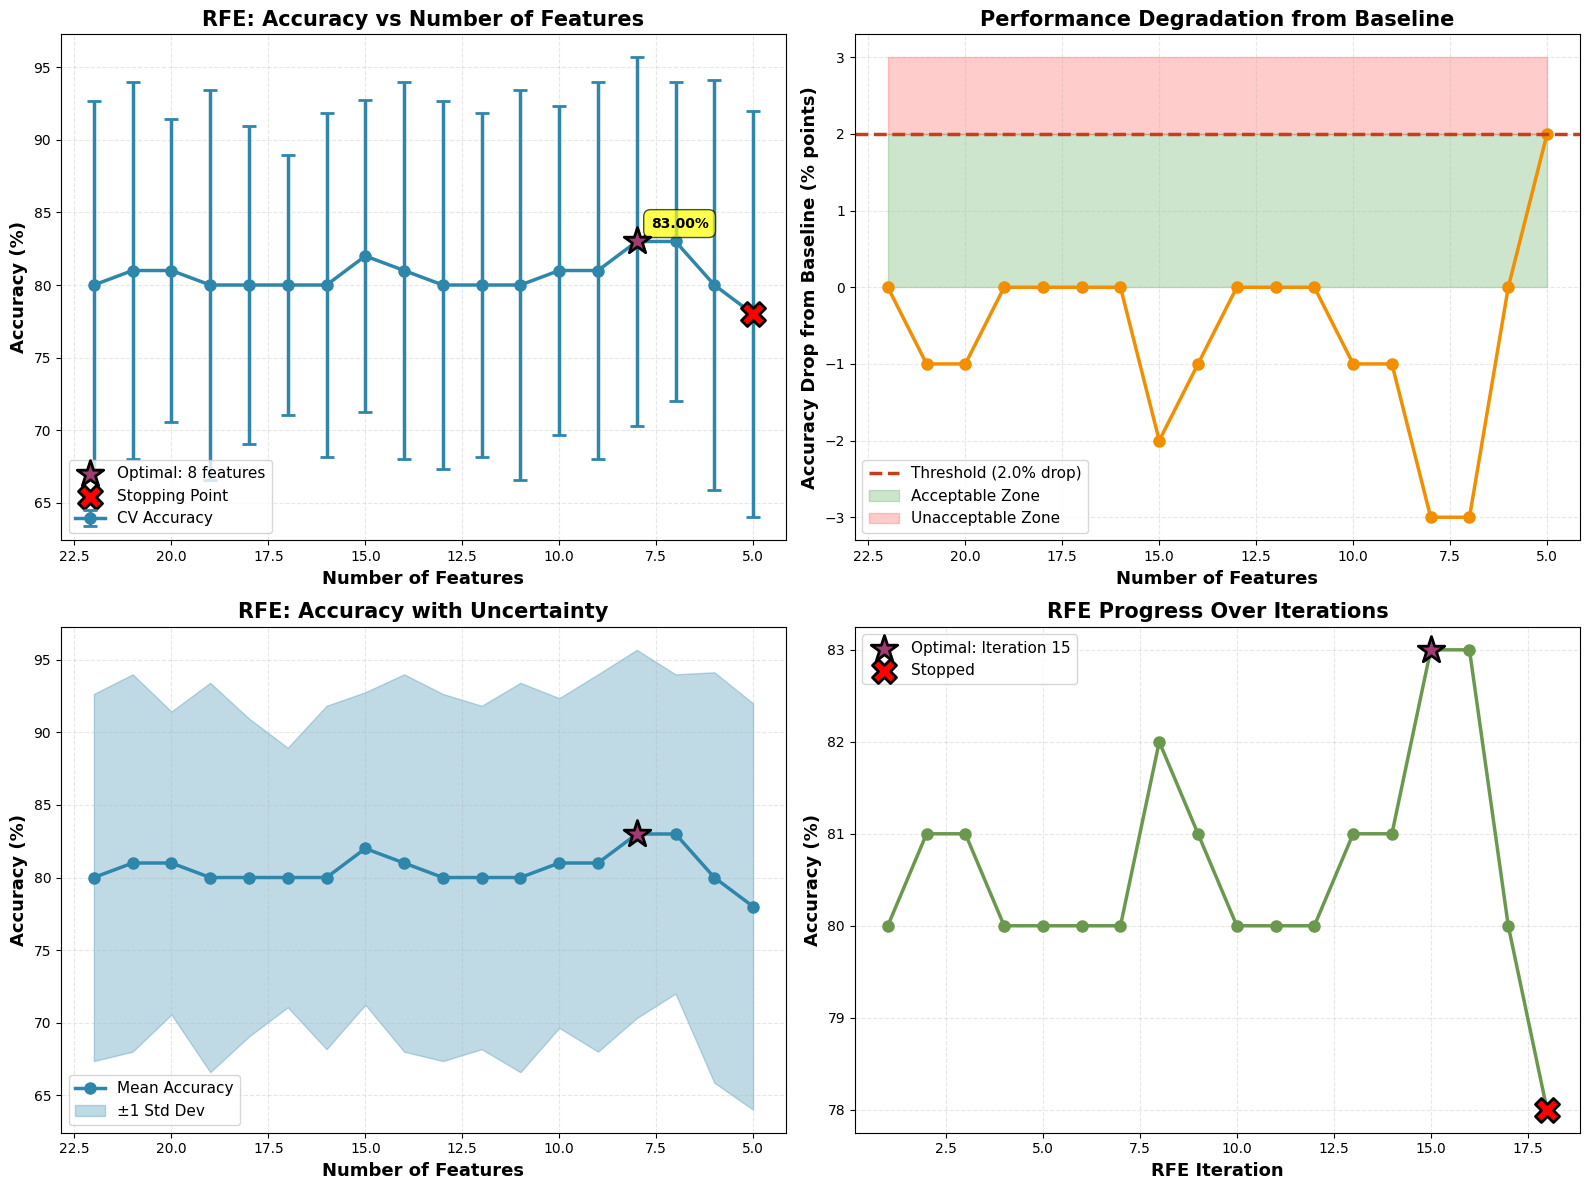

✅ Saved: rfe_comprehensive_analysis.png


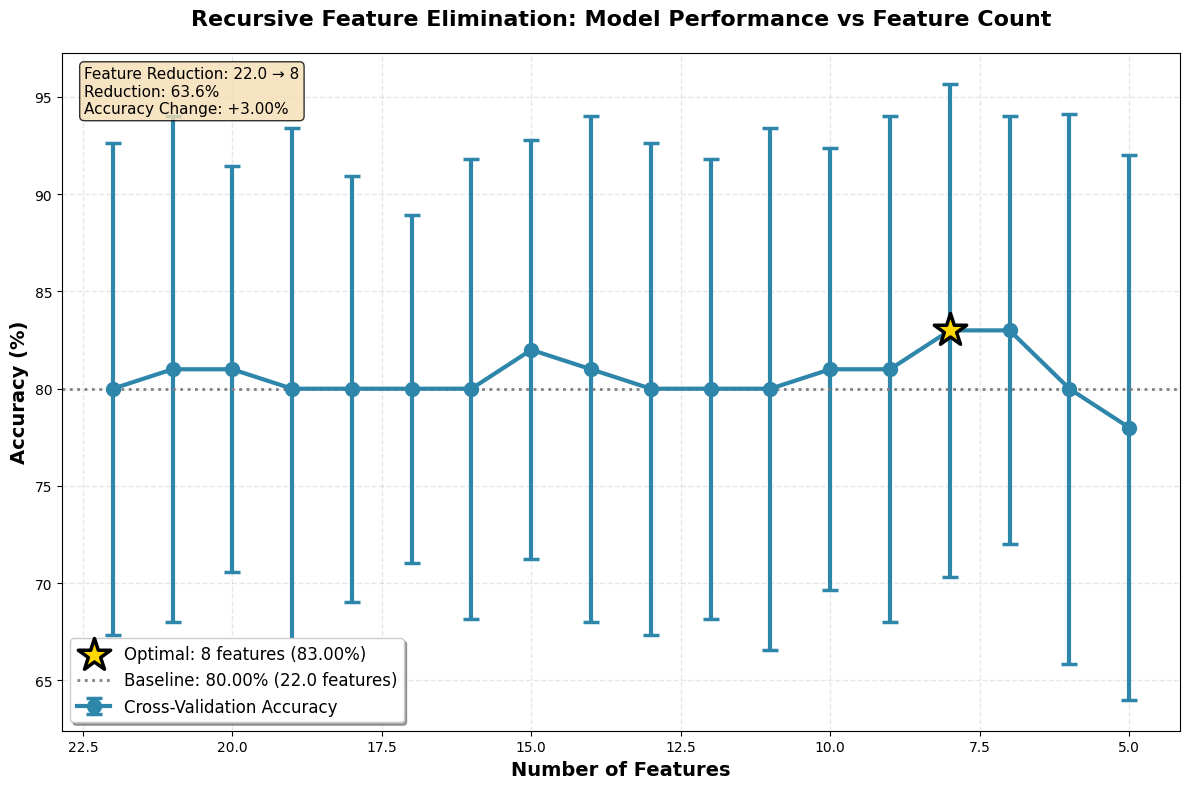

✅ Saved: rfe_for_thesis.png (publication-ready)


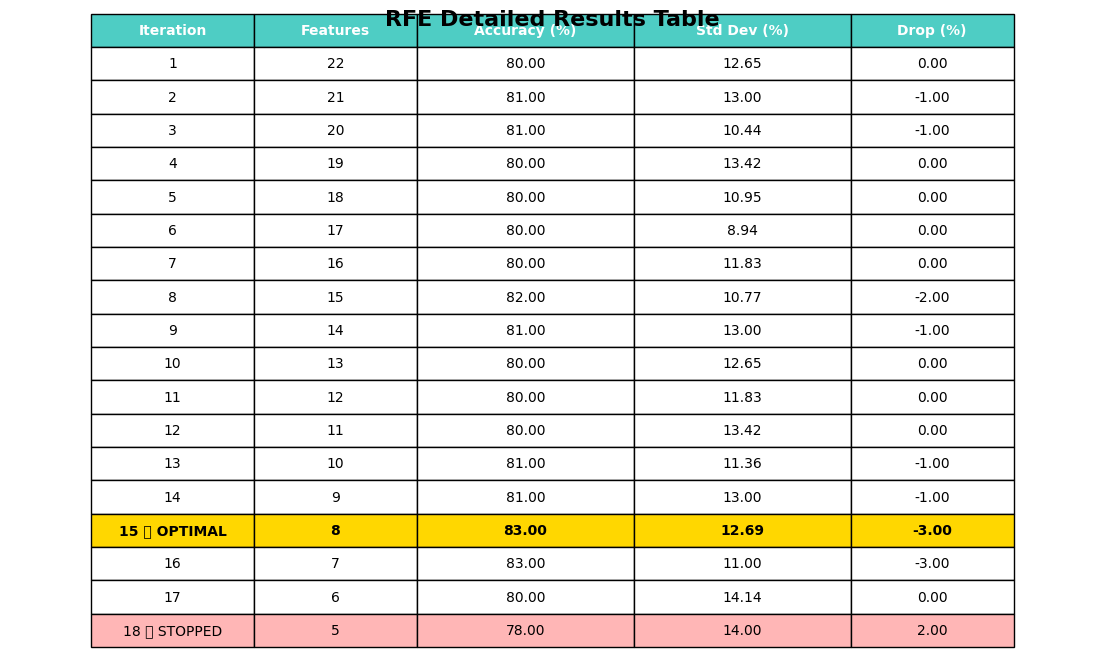

✅ Saved: rfe_results_table.png

SAVING RFE NUMERICAL RESULTS
✅ Saved: rfe_results_detailed.csv

📊 RFE Summary Statistics:
  Starting features: 22.0
  Optimal features: 8
  Final features: 5.0
  Feature reduction: 63.6%

  Starting accuracy: 80.00%
  Optimal accuracy: 83.00%
  Accuracy change: +3.00%

✅ RFE VISUALIZATION COMPLETE!

📁 Files Created:
  1. rfe_comprehensive_analysis.png - 4-panel detailed analysis
  2. rfe_for_thesis.png - Clean publication-ready plot
  3. rfe_results_table.png - Detailed results table
  4. rfe_results_detailed.csv - Numerical data


In [ ]:
# ========================================
# STEP 1: RFE ON TRAINING SET ONLY
# (To avoid data leakage - don't use test set!)
# ========================================
import time
import numpy as np

# Get training set
training_set = split_data['train']
n_train_samples = training_set.size().getInfo()

# Get all feature names
all_features = filtered_bands.getInfo()
n_features_total = len(all_features)

# ========================================
# RFE CONFIGURATION
# ========================================

STOPPING_STRATEGY = "absolute_drop"
absolute_drop_threshold = 2.0  # Stop if accuracy drops >2%
elimination_step = 1  # Remove 1 feature per iteration
min_features = 5  # Safety limit
max_iterations = 20  # Safety limit


# ========================================
# RFE HELPER FUNCTIONS (TRAINING SET ONLY)
# ========================================
def rfe_train_test_iteration(features_list, train_data, hyperparams):
    """
    Perform internal 5-fold CV on TRAINING SET ONLY
    Returns average accuracy across folds
    """
    from sklearn.model_selection import StratifiedKFold

    # We'll do 5-fold CV within training set for speed
    n_folds = 10

    # Create stratified folds within training set
    train_cw = train_data.filter(ee.Filter.eq('class', 0))
    train_ng = train_data.filter(ee.Filter.eq('class', 1))

    cw_total = train_cw.size().getInfo()
    ng_total = train_ng.size().getInfo()

    # Add random column and sort
    cw_random = train_cw.randomColumn('rfe_fold', 42)
    ng_random = train_ng.randomColumn('rfe_fold', 42)
    cw_sorted = cw_random.sort('rfe_fold')
    ng_sorted = ng_random.sort('rfe_fold')

    # Convert to lists
    cw_list = cw_sorted.toList(cw_total)
    ng_list = ng_sorted.toList(ng_total)

    # Calculate fold sizes
    cw_fold_size = int(cw_total / n_folds)
    ng_fold_size = int(ng_total / n_folds)

    fold_accuracies = []
    bands_to_use = ee.List(features_list)

    for fold_idx in range(n_folds):
        # Create test fold
        cw_test_start = fold_idx * cw_fold_size
        cw_test_end = (fold_idx + 1) * cw_fold_size if fold_idx < n_folds - 1 else cw_total

        ng_test_start = fold_idx * ng_fold_size
        ng_test_end = (fold_idx + 1) * ng_fold_size if fold_idx < n_folds - 1 else ng_total

        cw_test_fold = ee.FeatureCollection(cw_list.slice(cw_test_start, cw_test_end))
        ng_test_fold = ee.FeatureCollection(ng_list.slice(ng_test_start, ng_test_end))

        test_fold = cw_test_fold.merge(ng_test_fold)

        # Create train fold (all except test)
        cw_train_part1 = ee.FeatureCollection(cw_list.slice(0, cw_test_start))
        cw_train_part2 = ee.FeatureCollection(cw_list.slice(cw_test_end, cw_total))

        ng_train_part1 = ee.FeatureCollection(ng_list.slice(0, ng_test_start))
        ng_train_part2 = ee.FeatureCollection(ng_list.slice(ng_test_end, ng_total))

        train_fold = cw_train_part1.merge(cw_train_part2).merge(ng_train_part1).merge(ng_train_part2)

        # Train classifier
        classifier = ee.Classifier.smileRandomForest(
            numberOfTrees=hyperparams['numberOfTrees'],
            variablesPerSplit=hyperparams['variablesPerSplit'],
            minLeafPopulation=hyperparams['minLeafPopulation'],
            bagFraction=hyperparams['bagFraction'],
            seed=42
        )

        trained = classifier.train(
            features=train_fold,
            classProperty='class',
            inputProperties=bands_to_use
        )

        # Predict
        predictions = test_fold.classify(trained)

        # Get accuracy
        error_matrix = predictions.errorMatrix('class', 'classification')
        accuracy = error_matrix.accuracy().getInfo()

        fold_accuracies.append(accuracy)

    return {
        'accuracy_mean': np.mean(fold_accuracies),
        'accuracy_std': np.std(fold_accuracies)
    }

def get_feature_importance_train(features_list, training_data, hyperparams):
    """
    Train on training set only and get feature importance
    """
    bands_to_use = ee.List(features_list)

    classifier = ee.Classifier.smileRandomForest(
        numberOfTrees=hyperparams['numberOfTrees'],
        variablesPerSplit=hyperparams['variablesPerSplit'],
        minLeafPopulation=hyperparams['minLeafPopulation'],
        bagFraction=hyperparams['bagFraction'],
        seed=42
    )

    trained = classifier.train(
        features=training_data,
        classProperty='class',
        inputProperties=bands_to_use
    )

    explanation = trained.explain().getInfo()
    importance_dict = explanation.get('importance', {})

    return importance_dict


# ========================================
# RFE MAIN LOOP (ON TRAINING SET ONLY)
# ========================================

rfe_results = []
current_features = all_features.copy()
iteration = 0

start_time = time.time()

print(f"\n{'='*60}")
print("STARTING RFE ON TRAINING SET...")
print(f"{'='*60}\n")

while True:
    iteration += 1
    iter_start = time.time()

    n_current = len(current_features)

    print(f"{'='*60}")
    print(f"RFE ITERATION {iteration}")
    print(f"{'='*60}")
    print(f"Current features: {n_current}")

    # Evaluate with 5-fold CV on training set
    print(f"\n  Running 5-fold CV on training set...")
    cv_results = rfe_train_test_iteration(current_features, training_set, best_params)

    accuracy = cv_results['accuracy_mean']

    # Calculate drops
    if len(rfe_results) > 0:
        baseline_accuracy = rfe_results[0]['accuracy_mean']
        drop_from_baseline = (baseline_accuracy - accuracy) * 100
    else:
        baseline_accuracy = accuracy
        drop_from_baseline = 0

    print(f"\n  ✅ 5-Fold CV Results:")
    print(f"     Accuracy: {accuracy*100:.2f}% (±{cv_results['accuracy_std']*100:.2f}%)")

    if len(rfe_results) > 0:
        print(f"     Drop from baseline: {drop_from_baseline:.2f} percentage points")

    # Store results
    rfe_results.append({
        'iteration': iteration,
        'n_features': n_current,
        'features': current_features.copy(),
        'accuracy_mean': accuracy,
        'accuracy_std': cv_results['accuracy_std'],
        'drop_from_baseline': drop_from_baseline / 100
    })

    # Check stopping condition
    should_stop = False

    if len(rfe_results) > 1:
        if drop_from_baseline > absolute_drop_threshold:
            should_stop = True
            print(f"\n  🛑 STOPPING: Accuracy dropped by {drop_from_baseline:.2f}% (threshold: {absolute_drop_threshold}%)")

    if n_current <= min_features:
        should_stop = True
        print(f"\n  🛑 STOPPING: Reached minimum features ({min_features})")

    if iteration >= max_iterations:
        should_stop = True
        print(f"\n  🛑 STOPPING: Reached maximum iterations ({max_iterations})")

    if should_stop:
        if len(rfe_results) > 1:
            optimal_iter = rfe_results[-2]  # Previous iteration
            print(f"\n  ✅ OPTIMAL: Iteration {optimal_iter['iteration']} with {optimal_iter['n_features']} features")
        else:
            optimal_iter = rfe_results[-1]
            print(f"\n  ✅ OPTIMAL: Keeping all {optimal_iter['n_features']} features")
        break

    # Continue: Get feature importance
    print(f"\n  ➡️  Extracting feature importance...")
    importance_dict = get_feature_importance_train(current_features, training_set, best_params)

    # Sort by importance
    sorted_features = sorted(importance_dict.items(), key=lambda x: x[1])

    # Remove least important
    n_to_remove = min(elimination_step, len(current_features) - min_features)
    features_to_remove = [feat for feat, _ in sorted_features[:n_to_remove]]

    print(f"\n  🗑️  Removing: {features_to_remove}")
    current_features = [f for f in current_features if f not in features_to_remove]

    iter_time = time.time() - iter_start
    print(f"\n  ⏱️  Iteration time: {iter_time/60:.1f} min")

total_time = time.time() - start_time

# Find best iteration
best_rfe = max(rfe_results, key=lambda x: x['accuracy_mean'])
rfe_selected_features = best_rfe['features']

print("\n" + "="*60)
print("🎉 RFE COMPLETE!")
print("="*60)
print(f"Total time: {total_time/60:.1f} minutes")
print(f"\n🏆 OPTIMAL FEATURES:")
print(f"   Number: {best_rfe['n_features']}")
print(f"   Features: {rfe_selected_features}")
print(f"   Training CV Accuracy: {best_rfe['accuracy_mean']*100:.2f}% (±{best_rfe['accuracy_std']*100:.2f}%)")

# ========================================
# VISUALIZE RFE RESULTS
# ========================================

print("\n" + "="*60)
print("CREATING RFE VISUALIZATIONS")
print("="*60)

import matplotlib.pyplot as plt
import numpy as np

# Convert results to DataFrame for easier plotting
rfe_df = pd.DataFrame([{
    'iteration': r['iteration'],
    'n_features': r['n_features'],
    'accuracy_mean': r['accuracy_mean'] * 100,  # Convert to percentage
    'accuracy_std': r['accuracy_std'] * 100,
    'drop_from_baseline': r['drop_from_baseline'] * 100
} for r in rfe_results])

print(f"\nCreating {len(rfe_df)} iteration plots...")

# ========================================
# FIGURE 1: COMPREHENSIVE RFE VISUALIZATION
# ========================================

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Accuracy vs Number of Features (with error bars)
ax1 = axes[0, 0]
ax1.errorbar(rfe_df['n_features'], rfe_df['accuracy_mean'],
             yerr=rfe_df['accuracy_std'],
             marker='o', markersize=8, capsize=5, capthick=2,
             linewidth=2.5, color='#2E86AB', label='CV Accuracy')

# Mark optimal point
best_idx = rfe_df['accuracy_mean'].idxmax()
ax1.scatter(rfe_df.loc[best_idx, 'n_features'],
           rfe_df.loc[best_idx, 'accuracy_mean'],
           color='#A23B72', s=400, marker='*', zorder=5,
           label=f'Optimal: {rfe_df.loc[best_idx, "n_features"]} features',
           edgecolors='black', linewidths=2)

# Mark stopping point
ax1.scatter(rfe_df.iloc[-1]['n_features'],
           rfe_df.iloc[-1]['accuracy_mean'],
           color='red', s=300, marker='X', zorder=5,
           label='Stopping Point',
           edgecolors='black', linewidths=2)

ax1.set_xlabel('Number of Features', fontsize=13, fontweight='bold')
ax1.set_ylabel('Accuracy (%)', fontsize=13, fontweight='bold')
ax1.set_title('RFE: Accuracy vs Number of Features', fontsize=15, fontweight='bold')
ax1.legend(fontsize=11, loc='best')
ax1.grid(True, alpha=0.3, linestyle='--')
ax1.invert_xaxis()  # More features on left, fewer on right

# Add text annotation for optimal point
ax1.annotate(f'{rfe_df.loc[best_idx, "accuracy_mean"]:.2f}%',
            xy=(rfe_df.loc[best_idx, 'n_features'], rfe_df.loc[best_idx, 'accuracy_mean']),
            xytext=(10, 10), textcoords='offset points',
            fontsize=10, fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.7),
            arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

# Plot 2: Accuracy Drop from Baseline
ax2 = axes[0, 1]
ax2.plot(rfe_df['n_features'], rfe_df['drop_from_baseline'],
         marker='o', markersize=8, linewidth=2.5, color='#F18F01')

# Add threshold line
ax2.axhline(y=absolute_drop_threshold, color='#C73E1D',
           linestyle='--', linewidth=2.5,
           label=f'Threshold ({absolute_drop_threshold}% drop)')

# Fill acceptable zone
ax2.fill_between(rfe_df['n_features'], 0, absolute_drop_threshold,
                alpha=0.2, color='green', label='Acceptable Zone')

# Fill unacceptable zone
ax2.fill_between(rfe_df['n_features'], absolute_drop_threshold,
                rfe_df['drop_from_baseline'].max() + 1,
                alpha=0.2, color='red', label='Unacceptable Zone')

ax2.set_xlabel('Number of Features', fontsize=13, fontweight='bold')
ax2.set_ylabel('Accuracy Drop from Baseline (% points)', fontsize=13, fontweight='bold')
ax2.set_title('Performance Degradation from Baseline', fontsize=15, fontweight='bold')
ax2.legend(fontsize=11, loc='best')
ax2.grid(True, alpha=0.3, linestyle='--')
ax2.invert_xaxis()

# Plot 3: Accuracy with Standard Deviation Bands
ax3 = axes[1, 0]
ax3.plot(rfe_df['n_features'], rfe_df['accuracy_mean'],
        marker='o', markersize=8, linewidth=2.5, color='#2E86AB', label='Mean Accuracy')

# Add confidence bands (±1 std)
ax3.fill_between(rfe_df['n_features'],
                rfe_df['accuracy_mean'] - rfe_df['accuracy_std'],
                rfe_df['accuracy_mean'] + rfe_df['accuracy_std'],
                alpha=0.3, color='#2E86AB', label='±1 Std Dev')

# Mark optimal
ax3.scatter(rfe_df.loc[best_idx, 'n_features'],
           rfe_df.loc[best_idx, 'accuracy_mean'],
           color='#A23B72', s=400, marker='*', zorder=5,
           edgecolors='black', linewidths=2)

ax3.set_xlabel('Number of Features', fontsize=13, fontweight='bold')
ax3.set_ylabel('Accuracy (%)', fontsize=13, fontweight='bold')
ax3.set_title('RFE: Accuracy with Uncertainty', fontsize=15, fontweight='bold')
ax3.legend(fontsize=11, loc='best')
ax3.grid(True, alpha=0.3, linestyle='--')
ax3.invert_xaxis()

# Plot 4: Iteration Progress
ax4 = axes[1, 1]
ax4.plot(rfe_df['iteration'], rfe_df['accuracy_mean'],
        marker='o', markersize=8, linewidth=2.5, color='#6A994E')

# Mark optimal iteration
ax4.scatter(rfe_df.loc[best_idx, 'iteration'],
           rfe_df.loc[best_idx, 'accuracy_mean'],
           color='#A23B72', s=400, marker='*', zorder=5,
           label=f'Optimal: Iteration {rfe_df.loc[best_idx, "iteration"]}',
           edgecolors='black', linewidths=2)

# Mark stopping iteration
ax4.scatter(rfe_df.iloc[-1]['iteration'],
           rfe_df.iloc[-1]['accuracy_mean'],
           color='red', s=300, marker='X', zorder=5,
           label='Stopped',
           edgecolors='black', linewidths=2)

ax4.set_xlabel('RFE Iteration', fontsize=13, fontweight='bold')
ax4.set_ylabel('Accuracy (%)', fontsize=13, fontweight='bold')
ax4.set_title('RFE Progress Over Iterations', fontsize=15, fontweight='bold')
ax4.legend(fontsize=11, loc='best')
ax4.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig('rfe_comprehensive_analysis.png', dpi=300, bbox_inches='tight')
plt.show()
print("✅ Saved: rfe_comprehensive_analysis.png")

# ========================================
# FIGURE 2: SINGLE CLEAN PLOT FOR THESIS
# ========================================

fig, ax = plt.subplots(figsize=(12, 8))

# Main accuracy line with error bars
ax.errorbar(rfe_df['n_features'], rfe_df['accuracy_mean'],
           yerr=rfe_df['accuracy_std'],
           marker='o', markersize=10, capsize=6, capthick=2.5,
           linewidth=3, color='#2E86AB',
           label='Cross-Validation Accuracy', zorder=2)

# Mark optimal point (larger and more prominent)
ax.scatter(rfe_df.loc[best_idx, 'n_features'],
          rfe_df.loc[best_idx, 'accuracy_mean'],
          color='gold', s=600, marker='*', zorder=5,
          label=f'Optimal: {rfe_df.loc[best_idx, "n_features"]} features ({rfe_df.loc[best_idx, "accuracy_mean"]:.2f}%)',
          edgecolors='black', linewidths=2.5)

# Add baseline reference line
baseline_acc = rfe_df.iloc[0]['accuracy_mean']
ax.axhline(y=baseline_acc, color='gray', linestyle=':', linewidth=2,
          label=f'Baseline: {baseline_acc:.2f}% ({rfe_df.iloc[0]["n_features"]} features)')

# Styling
ax.set_xlabel('Number of Features', fontsize=14, fontweight='bold')
ax.set_ylabel('Accuracy (%)', fontsize=14, fontweight='bold')
ax.set_title('Recursive Feature Elimination: Model Performance vs Feature Count',
            fontsize=16, fontweight='bold', pad=20)
ax.legend(fontsize=12, loc='best', frameon=True, shadow=True)
ax.grid(True, alpha=0.3, linestyle='--', linewidth=1)
ax.invert_xaxis()

# Add text box with summary
textstr = f'Feature Reduction: {rfe_df.iloc[0]["n_features"]} → {rfe_df.loc[best_idx, "n_features"]}\n'
textstr += f'Reduction: {(1 - rfe_df.loc[best_idx, "n_features"]/rfe_df.iloc[0]["n_features"])*100:.1f}%\n'
textstr += f'Accuracy Change: {rfe_df.loc[best_idx, "accuracy_mean"] - baseline_acc:+.2f}%'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=11,
       verticalalignment='top', bbox=props)

plt.tight_layout()
plt.savefig('rfe_for_thesis.png', dpi=300, bbox_inches='tight')
plt.show()
print("✅ Saved: rfe_for_thesis.png (publication-ready)")

# ========================================
# FIGURE 3: DETAILED STATISTICS TABLE
# ========================================

fig, ax = plt.subplots(figsize=(14, max(6, len(rfe_df)*0.4)))
ax.axis('tight')
ax.axis('off')

# Create table data
table_data = []
table_data.append(['Iteration', 'Features', 'Accuracy (%)', 'Std Dev (%)', 'Drop (%)'])

for idx, row in rfe_df.iterrows():
    iteration_marker = ''
    if idx == best_idx:
        iteration_marker = ' ⭐ OPTIMAL'
    elif idx == len(rfe_df) - 1:
        iteration_marker = ' 🛑 STOPPED'

    table_data.append([
        f"{int(row['iteration'])}{iteration_marker}",
        f"{int(row['n_features'])}",
        f"{row['accuracy_mean']:.2f}",
        f"{row['accuracy_std']:.2f}",
        f"{row['drop_from_baseline']:.2f}"
    ])

table = ax.table(cellText=table_data, cellLoc='center', loc='center',
                colWidths=[0.15, 0.15, 0.2, 0.2, 0.15])

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)

# Style header row
for i in range(5):
    cell = table[(0, i)]
    cell.set_facecolor('#4ECDC4')
    cell.set_text_props(weight='bold', color='white')

# Highlight optimal row
if best_idx < len(table_data) - 1:
    for i in range(5):
        cell = table[(best_idx + 1, i)]
        cell.set_facecolor('#FFD700')
        cell.set_text_props(weight='bold')

# Highlight stopped row
for i in range(5):
    cell = table[(len(table_data) - 1, i)]
    cell.set_facecolor('#FFB6B6')

plt.title('RFE Detailed Results Table', fontsize=16, fontweight='bold', pad=20)
plt.savefig('rfe_results_table.png', dpi=300, bbox_inches='tight')
plt.show()
print("✅ Saved: rfe_results_table.png")

# ========================================
# SAVE NUMERICAL RESULTS
# ========================================

print("\n" + "="*60)
print("SAVING RFE NUMERICAL RESULTS")
print("="*60)

# Save to CSV
rfe_df.to_csv('rfe_results_detailed.csv', index=False)
print("✅ Saved: rfe_results_detailed.csv")

# Display summary statistics
print("\n📊 RFE Summary Statistics:")
print(f"  Starting features: {rfe_df.iloc[0]['n_features']}")
print(f"  Optimal features: {rfe_df.loc[best_idx, 'n_features']}")
print(f"  Final features: {rfe_df.iloc[-1]['n_features']}")
print(f"  Feature reduction: {(1 - rfe_df.loc[best_idx, 'n_features']/rfe_df.iloc[0]['n_features'])*100:.1f}%")
print(f"\n  Starting accuracy: {rfe_df.iloc[0]['accuracy_mean']:.2f}%")
print(f"  Optimal accuracy: {rfe_df.loc[best_idx, 'accuracy_mean']:.2f}%")
print(f"  Accuracy change: {rfe_df.loc[best_idx, 'accuracy_mean'] - rfe_df.iloc[0]['accuracy_mean']:+.2f}%")

print("\n" + "="*60)
print("✅ RFE VISUALIZATION COMPLETE!")
print("="*60)

print("\n📁 Files Created:")
print("  1. rfe_comprehensive_analysis.png - 4-panel detailed analysis")
print("  2. rfe_for_thesis.png - Clean publication-ready plot")
print("  3. rfe_results_table.png - Detailed results table")
print("  4. rfe_results_detailed.csv - Numerical data")



In [ ]:
# ========================================
# STEP 2: TRAIN WITH SELECTED FEATURES
# ========================================
selected_bands = ee.List(rfe_selected_features)

# Train classifier with SELECTED features
classifier_selected = ee.Classifier.smileRandomForest(
    numberOfTrees=best_params['numberOfTrees'],
    variablesPerSplit=best_params['variablesPerSplit'],
    minLeafPopulation=best_params['minLeafPopulation'],
    bagFraction=best_params['bagFraction'],
    seed=42
)

trained_model_selected = classifier_selected.train(
    features=training_set,
    classProperty='class',
    inputProperties=selected_bands  # Only selected features!
)

print("✅ Model trained with selected features!")

# ========================================
# STEP 3: TEST WITH SELECTED FEATURES - COMPREHENSIVE METRICS
# ========================================

print("\n" + "="*60)
print("TEST ON HELD-OUT TEST SET - COMPREHENSIVE EVALUATION")
print("="*60)

test_set = split_data['test']

print(f"\nTesting on {test_set.size().getInfo()} held-out samples...")
print(f"Using {len(rfe_selected_features)} RFE-selected features")

# Classify test set with selected features
test_predictions_selected = test_set.classify(trained_model_selected)

# Get metrics
error_matrix_selected = test_predictions_selected.errorMatrix('class', 'classification')
test_accuracy_selected = error_matrix_selected.accuracy().getInfo()
test_kappa_selected = error_matrix_selected.kappa().getInfo()

# Confusion matrix
cm_array_selected = error_matrix_selected.array().getInfo()
tn, fp = cm_array_selected[0][0], cm_array_selected[0][1]
fn, tp = cm_array_selected[1][0], cm_array_selected[1][1]

# ========================================
# BASIC METRICS
# ========================================

print(f"\n{'='*60}")
print("BASIC METRICS")
print(f"{'='*60}")

print(f"\n✅ Overall Performance:")
print(f"  Accuracy: {test_accuracy_selected*100:.2f}%")
print(f"  Kappa: {test_kappa_selected:.3f}")

print(f"\n📊 Confusion Matrix:")
print(f"           Predicted Presence  Predicted Absence")
print(f"  Actual Presence    {tn:5d}            {fp:5d}")
print(f"  Actual Absence     {fn:5d}            {tp:5d}")

# ========================================
# PER-CLASS METRICS (EXPANDED)
# ========================================

print(f"\n{'='*60}")
print("PER-CLASS METRICS")
print(f"{'='*60}")

# Calculate total samples and per-class support
total_samples = tn + fp + fn + tp
presence_samples = tn + fp
absence_samples = fn + tp

# Presence (Class 0) metrics
presence_precision = tn / (tn + fn) if (tn + fn) > 0 else 0  # User's Accuracy
presence_recall = tn / (tn + fp) if (tn + fp) > 0 else 0     # Producer's Accuracy
presence_f1 = 2 * (presence_precision * presence_recall) / (presence_precision + presence_recall) if (presence_precision + presence_recall) > 0 else 0
presence_specificity = tp / (tp + fn) if (tp + fn) > 0 else 0

# Commission and Omission errors for Presence
presence_commission_error = 1 - presence_precision
presence_omission_error = 1 - presence_recall

print(f"\n  📍 PRESENCE (Class 0):")
print(f"    Support: {presence_samples} samples ({presence_samples/total_samples*100:.1f}%)")
print(f"    Precision (User's Accuracy):     {presence_precision:.3f} ({presence_precision*100:.1f}%)")
print(f"    Recall (Producer's Accuracy):    {presence_recall:.3f} ({presence_recall*100:.1f}%)")
print(f"    F1-Score:                        {presence_f1:.3f}")
print(f"    Specificity:                     {presence_specificity:.3f}")
print(f"    Commission Error:                {presence_commission_error:.3f} ({presence_commission_error*100:.1f}%)")
print(f"    Omission Error:                  {presence_omission_error:.3f} ({presence_omission_error*100:.1f}%)")

# Absence (Class 1) metrics
absence_precision = tp / (tp + fp) if (tp + fp) > 0 else 0   # User's Accuracy
absence_recall = tp / (tp + fn) if (tp + fn) > 0 else 0      # Producer's Accuracy
absence_f1 = 2 * (absence_precision * absence_recall) / (absence_precision + absence_recall) if (absence_precision + absence_recall) > 0 else 0
absence_specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

# Commission and Omission errors for Absence
absence_commission_error = 1 - absence_precision
absence_omission_error = 1 - absence_recall

print(f"\n  📍 ABSENCE (Class 1):")
print(f"    Support: {absence_samples} samples ({absence_samples/total_samples*100:.1f}%)")
print(f"    Precision (User's Accuracy):     {absence_precision:.3f} ({absence_precision*100:.1f}%)")
print(f"    Recall (Producer's Accuracy):    {absence_recall:.3f} ({absence_recall*100:.1f}%)")
print(f"    F1-Score:                        {absence_f1:.3f}")
print(f"    Specificity:                     {absence_specificity:.3f}")
print(f"    Commission Error:                {absence_commission_error:.3f} ({absence_commission_error*100:.1f}%)")
print(f"    Omission Error:                  {absence_omission_error:.3f} ({absence_omission_error*100:.1f}%)")

# ========================================
# OVERALL F1-SCORES
# ========================================

print(f"\n{'='*60}")
print("OVERALL MODEL F1-SCORES")
print(f"{'='*60}")

# Macro F1 (unweighted average)
macro_f1 = (presence_f1 + absence_f1) / 2

# Weighted F1 (weighted by class support)
weighted_f1 = (presence_f1 * presence_samples + absence_f1 * absence_samples) / total_samples

print(f"\n  🎯 Overall F1-Scores:")
print(f"    Macro F1 (Unweighted):        {macro_f1:.3f}")
print(f"      → Simple average: ({presence_f1:.3f} + {absence_f1:.3f}) / 2")
print(f"      → Treats both classes equally")

print(f"\n    Weighted F1 (by support):     {weighted_f1:.3f}")
print(f"      → Weighted by class size")
print(f"      → Presence: {presence_samples} samples ({presence_samples/total_samples*100:.1f}%)")
print(f"      → Absence: {absence_samples} samples ({absence_samples/total_samples*100:.1f}%)")

# ========================================
# ADDITIONAL OVERALL METRICS
# ========================================

print(f"\n{'='*60}")
print("ADDITIONAL OVERALL METRICS")
print(f"{'='*60}")

# Macro averages (unweighted)
macro_precision = (presence_precision + absence_precision) / 2
macro_recall = (presence_recall + absence_recall) / 2

print(f"\n  📊 Macro-Averaged Metrics (Unweighted):")
print(f"    Precision: {macro_precision:.3f}")
print(f"    Recall:    {macro_recall:.3f}")
print(f"    F1-Score:  {macro_f1:.3f}")

# Weighted averages (by class support)
weighted_precision = (presence_precision * presence_samples + absence_precision * absence_samples) / total_samples
weighted_recall = (presence_recall * presence_samples + absence_recall * absence_samples) / total_samples

print(f"\n  📊 Weighted-Averaged Metrics (by support):")
print(f"    Precision: {weighted_precision:.3f}")
print(f"    Recall:    {weighted_recall:.3f}")
print(f"    F1-Score:  {weighted_f1:.3f}")

# Balanced accuracy
balanced_accuracy = (presence_recall + absence_recall) / 2

print(f"\n  ⚖️  Balanced Accuracy: {balanced_accuracy:.3f} ({balanced_accuracy*100:.1f}%)")
print(f"      → Average of per-class recalls")
print(f"      → Handles class imbalance well")

# Matthews Correlation Coefficient (MCC)
import math
numerator = (tp * tn) - (fp * fn)
denominator = math.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
mcc = numerator / denominator if denominator > 0 else 0

print(f"\n  🔢 Matthews Correlation Coefficient (MCC): {mcc:.3f}")
print(f"      → Range: -1 to +1 (where +1 is perfect)")
print(f"      → Considers all confusion matrix elements")

# ========================================
# ERROR ANALYSIS
# ========================================

print(f"\n{'='*60}")
print("ERROR ANALYSIS")
print(f"{'='*60}")

total_errors = fp + fn
error_rate = total_errors / total_samples

print(f"\n  ❌ Overall Errors:")
print(f"    Total errors: {total_errors} out of {total_samples} samples")
print(f"    Error rate: {error_rate:.3f} ({error_rate*100:.1f}%)")

print(f"\n  📊 Error Breakdown:")
print(f"    False Positives (FP): {fp}")
print(f"      → Absence incorrectly predicted as Presence")
print(f"      → {fp/total_samples*100:.1f}% of all samples")

print(f"\n    False Negatives (FN): {fn}")
print(f"      → Presence incorrectly predicted as Absence")
print(f"      → {fn/total_samples*100:.1f}% of all samples")

print(f"\n  ✅ Correct Predictions:")
print(f"    True Negatives (TN): {tn} (Presence correctly predicted)")
print(f"    True Positives (TP): {tp} (Absence correctly predicted)")
print(f"    Total correct: {tn + tp} ({(tn+tp)/total_samples*100:.1f}%)")

# ========================================
# INTERPRETATION
# ========================================

print(f"\n{'='*60}")
print("INTERPRETATION")
print(f"{'='*60}")

# F1 comparison
print(f"\n  📊 F1-Score Analysis:")
f1_diff = abs(macro_f1 - weighted_f1)
if f1_diff < 0.01:
    print(f"    ✅ Macro and Weighted F1 are nearly identical (Δ = {f1_diff:.4f})")
    print(f"       → Model performs consistently across classes")
elif weighted_f1 > macro_f1:
    print(f"    📊 Weighted F1 > Macro F1 (Δ = {weighted_f1 - macro_f1:.3f})")
    print(f"       → Model performs better on larger class (Absence)")
else:
    print(f"    📊 Macro F1 > Weighted F1 (Δ = {macro_f1 - weighted_f1:.3f})")
    print(f"       → Model performs better on smaller class (Presence)")

# Kappa interpretation
print(f"\n  📊 Cohen's Kappa Interpretation:")
if test_kappa_selected > 0.80:
    print(f"    🌟 Excellent agreement (κ = {test_kappa_selected:.3f})")
elif test_kappa_selected > 0.60:
    print(f"    ✅ Substantial agreement (κ = {test_kappa_selected:.3f})")
elif test_kappa_selected > 0.40:
    print(f"    👍 Moderate agreement (κ = {test_kappa_selected:.3f})")
elif test_kappa_selected > 0.20:
    print(f"    ⚠️  Fair agreement (κ = {test_kappa_selected:.3f})")
else:
    print(f"    ❌ Poor agreement (κ = {test_kappa_selected:.3f})")

# Balance analysis
print(f"\n  ⚖️  Class Balance Analysis:")
print(f"    Presence recall vs Absence recall: {presence_recall:.3f} vs {absence_recall:.3f}")
recall_diff = abs(presence_recall - absence_recall)
if recall_diff < 0.05:
    print(f"    ✅ Balanced performance across classes (Δ = {recall_diff:.3f})")
elif presence_recall > absence_recall:
    print(f"    📊 Better at detecting Presence (Δ = {recall_diff:.3f})")
else:
    print(f"    📊 Better at detecting Absence (Δ = {recall_diff:.3f})")

# ========================================
# SAVE COMPREHENSIVE METRICS
# ========================================

print(f"\n{'='*60}")
print("SAVING METRICS")
print(f"{'='*60}")

comprehensive_metrics = {
    'model_info': {
        'n_features': len(rfe_selected_features),
        'test_samples': int(total_samples),
        'presence_samples': int(presence_samples),
        'absence_samples': int(absence_samples)
    },
    'overall_metrics': {
        'accuracy': float(test_accuracy_selected),
        'kappa': float(test_kappa_selected),
        'balanced_accuracy': float(balanced_accuracy),
        'mcc': float(mcc),
        'error_rate': float(error_rate)
    },
    'overall_f1_scores': {
        'macro_f1': float(macro_f1),
        'weighted_f1': float(weighted_f1)
    },
    'macro_averages': {
        'precision': float(macro_precision),
        'recall': float(macro_recall),
        'f1_score': float(macro_f1)
    },
    'weighted_averages': {
        'precision': float(weighted_precision),
        'recall': float(weighted_recall),
        'f1_score': float(weighted_f1)
    },
    'confusion_matrix': {
        'tn': int(tn),
        'fp': int(fp),
        'fn': int(fn),
        'tp': int(tp)
    },
    'presence_class_0': {
        'support': int(presence_samples),
        'precision_users_accuracy': float(presence_precision),
        'recall_producers_accuracy': float(presence_recall),
        'f1_score': float(presence_f1),
        'specificity': float(presence_specificity),
        'commission_error': float(presence_commission_error),
        'omission_error': float(presence_omission_error)
    },
    'absence_class_1': {
        'support': int(absence_samples),
        'precision_users_accuracy': float(absence_precision),
        'recall_producers_accuracy': float(absence_recall),
        'f1_score': float(absence_f1),
        'specificity': float(absence_specificity),
        'commission_error': float(absence_commission_error),
        'omission_error': float(absence_omission_error)
    },
    'error_analysis': {
        'total_errors': int(total_errors),
        'false_positives': int(fp),
        'false_negatives': int(fn),
        'true_negatives': int(tn),
        'true_positives': int(tp)
    }
}

import json
with open('comprehensive_test_metrics.json', 'w') as f:
    json.dump(comprehensive_metrics, f, indent=2)

print("\n✅ Saved: comprehensive_test_metrics.json")

# Save as readable CSV
metrics_summary_df = pd.DataFrame([
    {'Category': 'Overall', 'Metric': 'Accuracy', 'Value': f"{test_accuracy_selected*100:.2f}%"},
    {'Category': 'Overall', 'Metric': 'Cohen\'s Kappa', 'Value': f"{test_kappa_selected:.3f}"},
    {'Category': 'Overall', 'Metric': 'Balanced Accuracy', 'Value': f"{balanced_accuracy*100:.2f}%"},
    {'Category': 'Overall', 'Metric': 'MCC', 'Value': f"{mcc:.3f}"},
    {'Category': 'Overall', 'Metric': 'Error Rate', 'Value': f"{error_rate*100:.1f}%"},
    {'Category': 'Overall F1', 'Metric': 'Macro F1', 'Value': f"{macro_f1:.3f}"},
    {'Category': 'Overall F1', 'Metric': 'Weighted F1', 'Value': f"{weighted_f1:.3f}"},
    {'Category': 'Presence', 'Metric': 'Precision', 'Value': f"{presence_precision:.3f}"},
    {'Category': 'Presence', 'Metric': 'Recall', 'Value': f"{presence_recall:.3f}"},
    {'Category': 'Presence', 'Metric': 'F1-Score', 'Value': f"{presence_f1:.3f}"},
    {'Category': 'Presence', 'Metric': 'Specificity', 'Value': f"{presence_specificity:.3f}"},
    {'Category': 'Absence', 'Metric': 'Precision', 'Value': f"{absence_precision:.3f}"},
    {'Category': 'Absence', 'Metric': 'Recall', 'Value': f"{absence_recall:.3f}"},
    {'Category': 'Absence', 'Metric': 'F1-Score', 'Value': f"{absence_f1:.3f}"},
    {'Category': 'Absence', 'Metric': 'Specificity', 'Value': f"{absence_specificity:.3f}"},
    {'Category': 'Macro Avg', 'Metric': 'Precision', 'Value': f"{macro_precision:.3f}"},
    {'Category': 'Macro Avg', 'Metric': 'Recall', 'Value': f"{macro_recall:.3f}"},
    {'Category': 'Macro Avg', 'Metric': 'F1-Score', 'Value': f"{macro_f1:.3f}"},
    {'Category': 'Weighted Avg', 'Metric': 'Precision', 'Value': f"{weighted_precision:.3f}"},
    {'Category': 'Weighted Avg', 'Metric': 'Recall', 'Value': f"{weighted_recall:.3f}"},
    {'Category': 'Weighted Avg', 'Metric': 'F1-Score', 'Value': f"{weighted_f1:.3f}"},
])

metrics_summary_df.to_csv('test_metrics_summary.csv', index=False)
print("✅ Saved: test_metrics_summary.csv")

print(f"\n{'='*60}")
print("✅ COMPREHENSIVE TEST EVALUATION COMPLETE!")
print(f"{'='*60}")

print(f"\n📊 Quick Summary:")
print(f"   Test Accuracy:  {test_accuracy_selected*100:.2f}%")
print(f"   Kappa:          {test_kappa_selected:.3f}")
print(f"   Macro F1:       {macro_f1:.3f}")
print(f"   Weighted F1:    {weighted_f1:.3f}")
print(f"   Balanced Acc:   {balanced_accuracy*100:.1f}%")

✅ Model trained with selected features!

TEST ON HELD-OUT TEST SET - COMPREHENSIVE EVALUATION

Testing on 26 held-out samples...
Using 8 RFE-selected features

BASIC METRICS

✅ Overall Performance:
  Accuracy: 76.92%
  Kappa: 0.552

📊 Confusion Matrix:
           Predicted Presence  Predicted Absence
  Actual Presence        8                0
  Actual Absence         6               12

PER-CLASS METRICS

  📍 PRESENCE (Class 0):
    Support: 8 samples (30.8%)
    Precision (User's Accuracy):     0.571 (57.1%)
    Recall (Producer's Accuracy):    1.000 (100.0%)
    F1-Score:                        0.727
    Specificity:                     0.667
    Commission Error:                0.429 (42.9%)
    Omission Error:                  0.000 (0.0%)

  📍 ABSENCE (Class 1):
    Support: 18 samples (69.2%)
    Precision (User's Accuracy):     1.000 (100.0%)
    Recall (Producer's Accuracy):    0.667 (66.7%)
    F1-Score:                        0.800
    Specificity:                     1.000



✅ Extracted importance for 8 features

📊 Top 10 Most Important Features:
band  importance  normalized_importance  percent_importance  cumulative_percent
 t09   76.518582               1.000000           14.474455           14.474455
 t20   73.703235               0.855658           13.941896           28.416351
 t30   72.132136               0.775107           13.644703           42.061054
 t22   63.964695               0.356364           12.099729           54.160783
 t26   63.002210               0.307017           11.917662           66.078445

📈 Importance Summary:
  Top 5 features: 66.08% of total importance
  Top 10 features: 100.00% of total importance
  Top 20 features: 100.00% of total importance

✅ Feature importance saved to 'feature_importance_train_test_model.csv'

Creating feature importance visualizations...


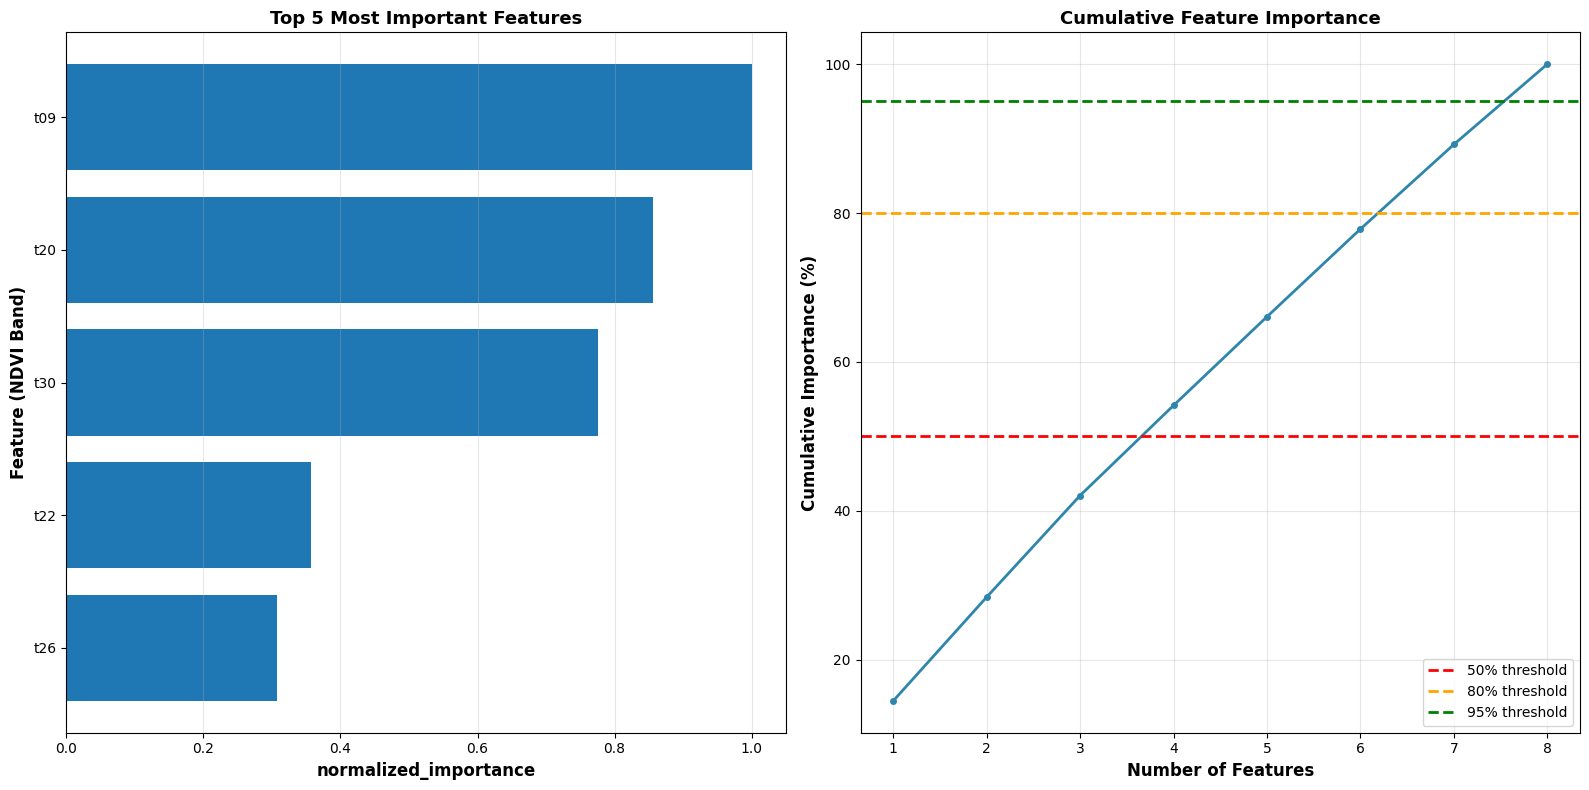

✅ Saved: feature_importance_train_test_model.png

🗓️  Most Important Time Periods:
  t09: 14.47% importance
  t20: 13.94% importance
  t30: 13.64% importance
  t22: 12.10% importance
  t26: 11.92% importance

Applying trained model to entire study area...
  Using all 22 features
✅ Classification complete!

CLASSIFICATION STATISTICS

Calculating area statistics...

📊 Classification Summary:

  Presence (Class 0):
    Pixels: 157,802.26274509792
    Area: 1,578.02 hectares (15,780,226 m²)
    Percentage: 16.89%

  Absence (Class 1):
    Pixels: 776,443.0313725313
    Area: 7,764.43 hectares (77,644,303 m²)
    Percentage: 83.11%

  Total Classified Area:
    Pixels: 934,245.2941176293
    Area: 9,342.45 hectares

✅ Statistics saved to 'classification_statistics.json'


In [ ]:
# ========================================
# EXTRACT FEATURE IMPORTANCE
# ========================================

# Get model explanation (includes feature importance)
model_explanation = trained_model_selected.explain().getInfo()

# Extract variable importance
if 'importance' in model_explanation:
    importance_dict = model_explanation['importance']

    # Convert to pandas DataFrame
    importance_df = pd.DataFrame([
        {'band': band, 'importance': importance_dict[band]}
        for band in importance_dict.keys()
    ])

    # Sort by importance (descending)
    importance_df = importance_df.sort_values('importance', ascending=False)

    # 🔹 Normalize importance values to 0–1
    importance_df['normalized_importance'] = (
        (importance_df['importance'] - importance_df['importance'].min()) /
        (importance_df['importance'].max() - importance_df['importance'].min())
    )
    # 🔹 Compute cumulative and percentage importance
    importance_df['cumulative_importance'] = importance_df['importance'].cumsum()
    importance_df['percent_importance'] = (importance_df['importance'] / importance_df['importance'].sum()) * 100
    importance_df['cumulative_percent'] = importance_df['percent_importance'].cumsum()

    print(f"\n✅ Extracted importance for {len(importance_df)} features")

    # Show top 10 most important features, including the normalized value
    print(f"\n📊 Top 10 Most Important Features:")
    print(importance_df.head(5)[['band', 'importance', 'normalized_importance', 'percent_importance', 'cumulative_percent']].to_string(index=False))

    # Summary statistics
    print(f"\n📈 Importance Summary:")
    print(f"  Top 5 features: {importance_df.head(5)['cumulative_percent'].iloc[-1]:.2f}% of total importance")
    print(f"  Top 10 features: {importance_df.head(10)['cumulative_percent'].iloc[-1]:.2f}% of total importance")
    print(f"  Top 20 features: {importance_df.head(20)['cumulative_percent'].iloc[-1]:.2f}% of total importance")

    # Save to CSV
    importance_df.to_csv('feature_importance_train_test_model.csv', index=False)
    print(f"\n✅ Feature importance saved to 'feature_importance_train_test_model.csv'")

    # ========================================
    # VISUALIZE FEATURE IMPORTANCE
    # ========================================

    print("\nCreating feature importance visualizations...")

    import matplotlib.pyplot as plt

    # Plot 1: Top 10 features (modified from 20 to 10 for consistency)
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))

    top_10 = importance_df.head(5)
    axes[0].barh(range(len(top_10)), top_10['normalized_importance'])
    axes[0].set_yticks(range(len(top_10)))
    axes[0].set_yticklabels(top_10['band'])
    axes[0].set_xlabel('normalized_importance', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Feature (NDVI Band)', fontsize=12, fontweight='bold')
    axes[0].set_title('Top 5 Most Important Features', fontsize=13, fontweight='bold')
    axes[0].invert_yaxis()
    axes[0].grid(True, alpha=0.3, axis='x')

    # Plot 2: Cumulative importance
    axes[1].plot(range(1, len(importance_df) + 1), importance_df['cumulative_percent'],
                 linewidth=2, marker='o', markersize=4, color='#2E86AB')
    axes[1].axhline(y=50, color='r', linestyle='--', linewidth=2, label='50% threshold')
    axes[1].axhline(y=80, color='orange', linestyle='--', linewidth=2, label='80% threshold')
    axes[1].axhline(y=95, color='green', linestyle='--', linewidth=2, label='95% threshold')
    axes[1].set_xlabel('Number of Features', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('Cumulative Importance (%)', fontsize=12, fontweight='bold')
    axes[1].set_title('Cumulative Feature Importance', fontsize=13, fontweight='bold')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('feature_importance_train_test_model.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("✅ Saved: feature_importance_train_test_model.png")

    # Most important time periods
    print(f"\n🗓️  Most Important Time Periods:")
    for idx, row in importance_df.head(5).iterrows():
        print(f"  {row['band']}: {row['percent_importance']:.2f}% importance")

else:
    print("⚠️  Could not extract feature importance")
    print("Model explanation structure:", model_explanation)
# ========================================
# CREATE CLASSIFICATION MAP
# ========================================

# ✅ SELECT ONLY THE RFE-SELECTED FEATURES FROM THE IMAGE
selected_bands_image = filtered_image.select(rfe_selected_features)

print(f"\nApplying trained model to entire study area...")
print(f"  Using all {len(temporal_bands.getInfo())} features")

# Apply the trained model to the SELECTED-FEATURES image
classified = selected_bands_image.classify(trained_model_selected)

print("✅ Classification complete!")

# ========================================
# CALCULATE CLASSIFICATION STATISTICS
# ========================================

print("\n" + "="*60)
print("CLASSIFICATION STATISTICS")
print("="*60)

print("\nCalculating area statistics...")

# Calculate pixel counts
pixel_counts = classified.reduceRegion(
    reducer=ee.Reducer.frequencyHistogram(),
    geometry=SLPP,
    scale=10,
    maxPixels=1e9
).getInfo()

# Extract counts
class_counts = pixel_counts.get('classification', {})

if '0' in class_counts and '1' in class_counts:
    presence_pixels = class_counts['0']
    absence_pixels = class_counts['1']
    total_pixels = presence_pixels + absence_pixels

    # Calculate areas (10m resolution = 100 m² per pixel)
    pixel_area = 100  # m²
    presence_area_m2 = presence_pixels * pixel_area
    absence_area_m2 = absence_pixels * pixel_area

    # Convert to hectares
    presence_area_ha = presence_area_m2 / 10000
    absence_area_ha = absence_area_m2 / 10000
    total_area_ha = (presence_area_m2 + absence_area_m2) / 10000

    # Calculate percentages
    presence_percent = (presence_pixels / total_pixels) * 100
    absence_percent = (absence_pixels / total_pixels) * 100

    print(f"\n📊 Classification Summary:")
    print(f"\n  Presence (Class 0):")
    print(f"    Pixels: {presence_pixels:,}")
    print(f"    Area: {presence_area_ha:,.2f} hectares ({presence_area_m2:,.0f} m²)")
    print(f"    Percentage: {presence_percent:.2f}%")

    print(f"\n  Absence (Class 1):")
    print(f"    Pixels: {absence_pixels:,}")
    print(f"    Area: {absence_area_ha:,.2f} hectares ({absence_area_m2:,.0f} m²)")
    print(f"    Percentage: {absence_percent:.2f}%")

    print(f"\n  Total Classified Area:")
    print(f"    Pixels: {total_pixels:,}")
    print(f"    Area: {total_area_ha:,.2f} hectares")

    # Save statistics
    classification_stats = {
        'presence': {
            'pixels': int(presence_pixels),
            'area_hectares': float(presence_area_ha),
            'area_m2': float(presence_area_m2),
            'percentage': float(presence_percent)
        },
        'absence': {
            'pixels': int(absence_pixels),
            'area_hectares': float(absence_area_ha),
            'area_m2': float(absence_area_m2),
            'percentage': float(absence_percent)
        },
        'total': {
            'pixels': int(total_pixels),
            'area_hectares': float(total_area_ha)
        }
    }

    import json
    with open('classification_statistics.json', 'w') as f:
        json.dump(classification_stats, f, indent=2)

    print(f"\n✅ Statistics saved to 'classification_statistics.json'")

else:
    print("⚠️  Could not calculate statistics. Check classification results.")



In [ ]:
# ========================================
# VISUALIZE CLASSIFICATION MAP - COMPLETE
# ========================================

print("\n" + "="*60)
print("CREATING INTERACTIVE MAP")
print("="*60)

import geemap

# Create map
Map = geemap.Map()
Map.centerObject(SLPP, 12)

print("\n📍 Adding layers to map...")

# Add boundary
Map.addLayer(SLPP, {'color': 'yellow'}, 'SLPP Boundary')
print("  ✅ Added: SLPP Boundary")

# Add classification
Map.addLayer(
    classified,
    {
        'min': 0,
        'max': 1,
        'palette': ['#FF6B6B', '#4ECDC4']
    },
    'Classification (RFE Model)',
    True
)
print("  ✅ Added: Classification layer")

# Add NDVI example
Map.addLayer(
    filtered_image.select('t30'),
    {'min': 0, 'max': 1, 'palette': ['red', 'yellow', 'green']},
    'NDVI (t30)',
    False
)
print("  ✅ Added: NDVI example (hidden)")

# Add training points
Map.addLayer(
    training_set.filter(ee.Filter.eq('class', 0)),
    {'color': 'red'},
    'Training Points - Presence',
    False
)
Map.addLayer(
    training_set.filter(ee.Filter.eq('class', 1)),
    {'color': 'blue'},
    'Training Points - Absence',
    False
)
print("  ✅ Added: Training points (hidden)")

# Add test points
Map.addLayer(
    test_set.filter(ee.Filter.eq('class', 0)),
    {'color': 'orange'},
    'Test Points - Presence',
    False
)
Map.addLayer(
    test_set.filter(ee.Filter.eq('class', 1)),
    {'color': 'cyan'},
    'Test Points - Absence',
    False
)
print("  ✅ Added: Test points (hidden)")

# Add legend
legend_dict = {
    'Presence (Class 0)': '#FF6B6B',
    'Absence (Class 1)': '#4ECDC4'
}
Map.add_legend(legend_title='Classification', legend_dict=legend_dict)
print("  ✅ Added: Legend")

print("\n" + "="*60)
print("🗺️  MAP READY!")
print("="*60)

print("\n📍 Map contains:")
print("  - SLPP Boundary (yellow outline)")
print("  - Classification (red=Presence, teal=Absence)")
print("  - NDVI band example (toggle on in layers)")
print("  - Training points (toggle on in layers)")
print("  - Test points (toggle on in layers)")

# Save as HTML
print("\n💾 Saving map as HTML file...")
Map.to_html('classification_map.html')
print("✅ Saved to 'classification_map.html'")

# Display in notebook
print("\n🗺️  Displaying map below...")
print("="*60 + "\n")

# CRITICAL: This must be the LAST line to display the map
display(Map)


CREATING INTERACTIVE MAP

📍 Adding layers to map...
  ✅ Added: SLPP Boundary
  ✅ Added: Classification layer
  ✅ Added: NDVI example (hidden)
  ✅ Added: Training points (hidden)
  ✅ Added: Test points (hidden)
  ✅ Added: Legend

🗺️  MAP READY!

📍 Map contains:
  - SLPP Boundary (yellow outline)
  - Classification (red=Presence, teal=Absence)
  - NDVI band example (toggle on in layers)
  - Training points (toggle on in layers)
  - Test points (toggle on in layers)

💾 Saving map as HTML file...
✅ Saved to 'classification_map.html'

🗺️  Displaying map below...



Map(center=[50.664448949104, -107.99542180658446], controls=(WidgetControl(options=['position', 'transparent_b…

In [ ]:
# Export
export_task = ee.batch.Export.image.toDrive(
    image=classified,
    description='Classified_CW_Clipped_Sentinel_10day_RGR_FINAL',
    folder='GEE_Exports',
    fileNamePrefix='Classified_CW_Clipped_Sentinel_10day_RGR_FINAL',
    scale=10,
    maxPixels=1e13,
    fileFormat='GeoTIFF'
)

export_task.start()
print('✅ Clipped classification export started!')

NameError: name 'ee' is not defined